In [1]:

import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
import warnings
import xgboost as xgb

from scipy import stats
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler, OneHotEncoder

warnings.filterwarnings('ignore')

In [2]:
df=pd.read_csv("./data/Luxury_watch.csv")
df

,Brand,Model,Case Material,Strap Material,Movement Type,Water Resistance,Case Diameter (mm),Case Thickness (mm),Band Width (mm),Dial Color,Crystal Material,Complications,Power Reserve,Price (USD)
0,Rolex,Submariner,Stainless Steel,Stainless Steel,Automatic,300 meters,40.0,13.00,20.0,Black,Sapphire,Date,48 hours,"9,500"
1,Omega,Seamaster,Titanium,Rubber,Automatic,600 meters,43.5,14.47,21.0,Blue,Sapphire,Date,60 hours,"5,800"
2,Tag Heuer,Carrera,Stainless Steel,Leather,Automatic,100 meters,41.0,13.00,20.0,White,Sapphire,Chronograph,42 hours,"4,200"
3,Breitling,Navitimer,Stainless Steel,Stainless Steel,Automatic,30 meters,43.0,14.25,22.0,Black,Sapphire,Chronograph,70 hours,"7,900"
4,Cartier,Tank Solo,Stainless Steel,Leather,Quartz,30 meters,31.0,6.05,20.0,Silver,Sapphire,NaN,NaN,"2,800"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
502,Breguet,Classique,18k Rose Gold,Leather,Automatic,30 meters,38.5,8.25,20.0,White,Sapphire,Date,38 hours,"21,500"
503,Blancpain,Fifty Fathoms,Stainless Steel,Fabric,Automatic,300 meters,45.0,15.50,23.0,Black,Sapphire,Date,120 hours,"13,500"
504,Longines,Master Collection,Stainless Steel,Leather,Automatic,30 meters,38.5,9.70,20.0,Blue,Sapphire,Date,64 hours,"1,800"
505,Vacheron Constantin,Overseas,Stainless Steel,Stainless Steel,Automatic,150 meters,41.5,11.00,22.0,Blue,Sapphire,Date,40 hours,"19,000"


In [3]:
df.columns

Index(['Brand', 'Model', 'Case Material', 'Strap Material', 'Movement Type',
       'Water Resistance', 'Case Diameter (mm)', 'Case Thickness (mm)',
       'Band Width (mm)', 'Dial Color', 'Crystal Material', 'Complications',
       'Power Reserve', 'Price (USD)'],
      dtype='object')

# 📌 Descripción de las columnas del dataset de relojes de lujo

| Columna             | Descripción |
|---------------------|-------------|
| **brand**          | Marca del reloj (ej. Rolex, Omega, Patek Philippe). |
| **model**          | Nombre o referencia del modelo específico. |
| **case_material**  | Material de la caja del reloj (ej. acero inoxidable, oro, titanio). |
| **strap_material** | Material de la correa (ej. cuero, acero, caucho). |
| **movement_type**  | Tipo de movimiento del reloj (ej. automático, cuarzo, manual). |
| **water_resistance** | Resistencia al agua en metros (ej. 50m, 100m). |
| **case_diameter_mm** | Diámetro de la caja en milímetros. |
| **case_thickness_mm** | Grosor de la caja en milímetros. |
| **band_width_mm**  | Ancho de la correa en milímetros. |
| **dial_color**     | Color de la esfera del reloj (ej. negro, azul, blanco). |
| **crystal_material** | Material del cristal (ej. zafiro, mineral, acrílico). |
| **complications**  | Funciones adicionales (ej. cronógrafo, calendario perpetuo). |
| **power_reserve**  | Reserva de marcha en horas (para relojes mecánicos). |
| **price_usd**      | Precio del reloj en dólares estadounidenses. |

📌 **Nota:** Estas características son clave para analizar y predecir precios, así como segmentar los relojes en diferentes categorías.  


In [4]:
# Renombramos las columnas: minúsculas y reemplazo de espacios por "_"
df.columns = df.columns.str.lower().str.replace(' ', '_')

print(df.columns)


Index(['brand', 'model', 'case_material', 'strap_material', 'movement_type',
       'water_resistance', 'case_diameter_(mm)', 'case_thickness_(mm)',
       'band_width_(mm)', 'dial_color', 'crystal_material', 'complications',
       'power_reserve', 'price_(usd)'],
      dtype='object')


### ANALISIS EXPLORATORIO

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 507 entries, 0 to 506
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   brand                507 non-null    object 
 1   model                507 non-null    object 
 2   case_material        507 non-null    object 
 3   strap_material       507 non-null    object 
 4   movement_type        507 non-null    object 
 5   water_resistance     507 non-null    object 
 6   case_diameter_(mm)   507 non-null    float64
 7   case_thickness_(mm)  507 non-null    float64
 8   band_width_(mm)      507 non-null    float64
 9   dial_color           507 non-null    object 
 10  crystal_material     507 non-null    object 
 11  complications        385 non-null    object 
 12  power_reserve        493 non-null    object 
 13  price_(usd)          506 non-null    object 
dtypes: float64(3), object(11)
memory usage: 55.6+ KB


| **Variable**              | **Tipo**          | **Tratamiento**                                              |
|---------------------------|-------------------|--------------------------------------------------------------|
| **brand**                 | Categórica        | Análisis de frecuencia y cardinalidad, codificación One-Hot   |
| **model**                 | Categórica        | Análisis de frecuencia, codificación One-Hot (si es necesario)|
| **case_material**         | Categórica        | Análisis de frecuencia, codificación One-Hot                  |
| **strap_material**        | Categórica        | Análisis de frecuencia, codificación One-Hot                  |
| **movement_type**         | Categórica        | Análisis de frecuencia, codificación One-Hot                  |
| **water_resistance**      | Categórica        | Análisis de frecuencia, codificación One-Hot                  |
| **case_diameter_(mm)**    | Numérica          | Escalado con StandardScaler si es necesario                   |
| **case_thickness_(mm)**   | Numérica          | Escalado con StandardScaler si es necesario                   |
| **band_width_(mm)**       | Numérica          | Escalado con StandardScaler si es necesario                   |
| **dial_color**            | Categórica        | Análisis de frecuencia, codificación One-Hot                  |
| **crystal_material**      | Categórica        | Análisis de frecuencia, codificación One-Hot                  |
| **complications**         | Categórica        | Análisis de frecuencia, imputación de valores nulos (si necesario), codificación One-Hot |
| **power_reserve**         | Categórica        | Análisis de frecuencia, imputación de valores nulos (si necesario), codificación One-Hot |
| **price_(usd)**           | Numérica (Target) | No requiere tratamiento inicial, solo conversión si es necesario (de objeto a numérico) |


#### LIMPIEZA Y TRANSFORMACION

In [6]:
# Verificar los valores nulos en la columna 'price_(usd)'
df['price_(usd)'].isnull().sum()

# Ver los primeros registros de 'price_(usd)' con valores nulos
df[df['price_(usd)'].isnull()]

,brand,model,case_material,strap_material,movement_type,water_resistance,case_diameter_(mm),case_thickness_(mm),band_width_(mm),dial_color,crystal_material,complications,power_reserve,price_(usd)
24,Bell & Ross,BR 03-92,Ceramic,Rubber,Automatic,100 meters,42.0,9.3,22.0,Black,Sapphire,NaN,"4,200",NaN


In [7]:
df = df.dropna(subset=['price_(usd)'])  # Eliminar filas con NaN en price_(usd)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 506 entries, 0 to 506
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   brand                506 non-null    object 
 1   model                506 non-null    object 
 2   case_material        506 non-null    object 
 3   strap_material       506 non-null    object 
 4   movement_type        506 non-null    object 
 5   water_resistance     506 non-null    object 
 6   case_diameter_(mm)   506 non-null    float64
 7   case_thickness_(mm)  506 non-null    float64
 8   band_width_(mm)      506 non-null    float64
 9   dial_color           506 non-null    object 
 10  crystal_material     506 non-null    object 
 11  complications        385 non-null    object 
 12  power_reserve        492 non-null    object 
 13  price_(usd)          506 non-null    object 
dtypes: float64(3), object(11)
memory usage: 59.3+ KB


In [9]:
df['price_(usd)'] = df['price_(usd)'].str.replace(',', '', regex=True)  # Quita comas del string
df['price_(usd)'] = pd.to_numeric(df['price_(usd)'], errors='coerce')  # Convierte a número entero


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 506 entries, 0 to 506
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   brand                506 non-null    object 
 1   model                506 non-null    object 
 2   case_material        506 non-null    object 
 3   strap_material       506 non-null    object 
 4   movement_type        506 non-null    object 
 5   water_resistance     506 non-null    object 
 6   case_diameter_(mm)   506 non-null    float64
 7   case_thickness_(mm)  506 non-null    float64
 8   band_width_(mm)      506 non-null    float64
 9   dial_color           506 non-null    object 
 10  crystal_material     506 non-null    object 
 11  complications        385 non-null    object 
 12  power_reserve        492 non-null    object 
 13  price_(usd)          506 non-null    int64  
dtypes: float64(3), int64(1), object(10)
memory usage: 59.3+ KB


In [11]:
# Imputar las variables 'complications' y 'power_reserve' con la moda
df['complications'].fillna(df['complications'].mode()[0], inplace=True)
df['power_reserve'].fillna(df['power_reserve'].mode()[0], inplace=True)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 506 entries, 0 to 506
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   brand                506 non-null    object 
 1   model                506 non-null    object 
 2   case_material        506 non-null    object 
 3   strap_material       506 non-null    object 
 4   movement_type        506 non-null    object 
 5   water_resistance     506 non-null    object 
 6   case_diameter_(mm)   506 non-null    float64
 7   case_thickness_(mm)  506 non-null    float64
 8   band_width_(mm)      506 non-null    float64
 9   dial_color           506 non-null    object 
 10  crystal_material     506 non-null    object 
 11  complications        506 non-null    object 
 12  power_reserve        506 non-null    object 
 13  price_(usd)          506 non-null    int64  
dtypes: float64(3), int64(1), object(10)
memory usage: 59.3+ KB


In [13]:
# Crear una nueva columna 'water_resistance_numeric' con solo el valor numérico
df['water_resistance_numeric'] = df['water_resistance'].str.extract('(\d+)').astype(float)

# Verificar la transformación
df[['water_resistance', 'water_resistance_numeric']].head()

,water_resistance,water_resistance_numeric
0,300 meters,300.0
1,600 meters,600.0
2,100 meters,100.0
3,30 meters,30.0
4,30 meters,30.0


In [14]:
# Crear una nueva columna 'power_reserve_numeric' con solo el valor numérico
df['power_reserve_numeric'] = df['power_reserve'].str.extract('(\d+)').astype(float)

# Verificar la transformación
df[['power_reserve', 'power_reserve_numeric']].head()

,power_reserve,power_reserve_numeric
0,48 hours,48.0
1,60 hours,60.0
2,42 hours,42.0
3,70 hours,70.0
4,60 hours,60.0


In [15]:
df

,brand,model,case_material,strap_material,movement_type,water_resistance,case_diameter_(mm),case_thickness_(mm),band_width_(mm),dial_color,crystal_material,complications,power_reserve,price_(usd),water_resistance_numeric,power_reserve_numeric
0,Rolex,Submariner,Stainless Steel,Stainless Steel,Automatic,300 meters,40.0,13.00,20.0,Black,Sapphire,Date,48 hours,9500,300.0,48.0
1,Omega,Seamaster,Titanium,Rubber,Automatic,600 meters,43.5,14.47,21.0,Blue,Sapphire,Date,60 hours,5800,600.0,60.0
2,Tag Heuer,Carrera,Stainless Steel,Leather,Automatic,100 meters,41.0,13.00,20.0,White,Sapphire,Chronograph,42 hours,4200,100.0,42.0
3,Breitling,Navitimer,Stainless Steel,Stainless Steel,Automatic,30 meters,43.0,14.25,22.0,Black,Sapphire,Chronograph,70 hours,7900,30.0,70.0
4,Cartier,Tank Solo,Stainless Steel,Leather,Quartz,30 meters,31.0,6.05,20.0,Silver,Sapphire,Date,60 hours,2800,30.0,60.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
502,Breguet,Classique,18k Rose Gold,Leather,Automatic,30 meters,38.5,8.25,20.0,White,Sapphire,Date,38 hours,21500,30.0,38.0
503,Blancpain,Fifty Fathoms,Stainless Steel,Fabric,Automatic,300 meters,45.0,15.50,23.0,Black,Sapphire,Date,120 hours,13500,300.0,120.0
504,Longines,Master Collection,Stainless Steel,Leather,Automatic,30 meters,38.5,9.70,20.0,Blue,Sapphire,Date,64 hours,1800,30.0,64.0
505,Vacheron Constantin,Overseas,Stainless Steel,Stainless Steel,Automatic,150 meters,41.5,11.00,22.0,Blue,Sapphire,Date,40 hours,19000,150.0,40.0


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 506 entries, 0 to 506
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   brand                     506 non-null    object 
 1   model                     506 non-null    object 
 2   case_material             506 non-null    object 
 3   strap_material            506 non-null    object 
 4   movement_type             506 non-null    object 
 5   water_resistance          506 non-null    object 
 6   case_diameter_(mm)        506 non-null    float64
 7   case_thickness_(mm)       506 non-null    float64
 8   band_width_(mm)           506 non-null    float64
 9   dial_color                506 non-null    object 
 10  crystal_material          506 non-null    object 
 11  complications             506 non-null    object 
 12  power_reserve             506 non-null    object 
 13  price_(usd)               506 non-null    int64  
 14  water_resistanc

En este DataFrame se nos presenta una variedad de variables, algunas de las cuales tienen valores nulos que hemos tratado adecuadamente para asegurar la integridad del análisis posterior. En primer lugar, observamos que la variable **price_usd** tenía solo un valor nulo, por lo que decidimos eliminar ese registro, ya que consideramos que no perderíamos información significativa y esta variable es nuestra variable objetivo, o target. Además, antes de continuar con el análisis, cambiamos el tipo de dato de **price_usd** de objeto a **int64**, dado que los valores venían representados con coma en lugar de punto. Para poder entender mejor cómo se distribuye esta variable, la visualizamos antes de eliminar el nulo, lo que nos permitió confirmar la decisión.

Posteriormente, para las variables **complications** y **power_reserve**, ambas con valores nulos en algunas filas, optamos por imputar estos valores utilizando la moda de cada una de ellas, ya que consideramos que este es un enfoque razonable para preservar la naturaleza de estas variables categóricas. Esto nos dejó con un total de 506 registros completos.

Además, identificamos que tanto **water_resistance** como **power_reserve** contenían información numérica junto con texto. Para poder utilizar estos datos en su forma numérica, creamos dos nuevas columnas: **water_resistance_numeric**, en la cual extraímos el valor numérico de la resistencia al agua eliminando el texto "metros", y **power_reserve_numeric**, en la cual también extraímos el valor numérico de la reserva de energía, eliminando la palabra "horas".

Con estos pasos, hemos limpiado el dataset de nulos y transformado las variables en el formato adecuado, asegurando que podamos proceder con un análisis más robusto, tanto para la regresión como para la segmentación de clusters. Este proceso de tratamiento de datos se puede considerar como una etapa crucial, y en este caso, hemos realizado los ajustes necesarios para asegurar la calidad de nuestros datos antes de cualquier análisis posterior.


##### ANALISIS DEL TARGET

In [17]:
target=['price_(usd)']

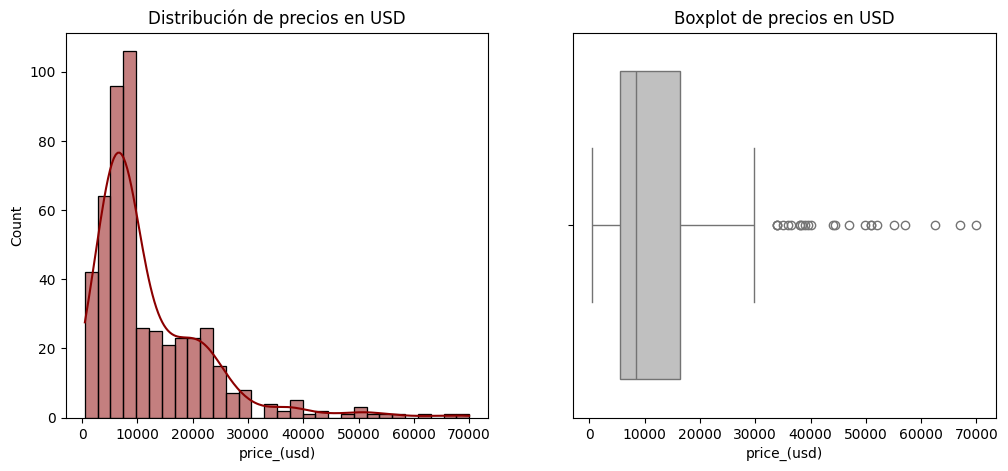

In [18]:
luxury_palette = ["gold", "champagne", "royalblue", "navy", "crimson", 
                  "charcoal", "silver", "mediumseagreen", "darkred", "black"]
# Ajustar el tamaño de las gráficas
plt.figure(figsize=(12, 5))

# Histograma
plt.subplot(1, 2, 1)
sns.histplot(df["price_(usd)"], bins=30, kde=True, color="darkred")
plt.title("Distribución de precios en USD")

# Boxplot
plt.subplot(1, 2, 2)
sns.boxplot(x=df["price_(usd)"], color="silver")
plt.title("Boxplot de precios en USD")

plt.show()

In [19]:
df.describe()

,case_diameter_(mm),case_thickness_(mm),band_width_(mm),price_(usd),water_resistance_numeric,power_reserve_numeric
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,41.044269,11.592866,21.103755,12082.964427,122.371542,59.268775
std,2.537492,2.491863,1.659538,10419.816968,149.305681,22.723192
min,27.500000,5.000000,15.000000,495.000000,30.000000,38.000000
25%,40.000000,9.800000,20.000000,5500.000000,50.000000,45.000000
50%,41.000000,12.025000,20.000000,8350.000000,100.000000,55.000000
75%,42.000000,13.300000,22.000000,16450.000000,120.000000,68.000000
max,46.500000,17.500000,28.000000,70000.000000,2000.000000,270.000000


#### Análisis del Target (Precio en USD)

Al observar el gráfico de distribución de los precios de los relojes de lujo, podemos ver que la distribución está **sesgada hacia la derecha**. La mayoría de los valores se agrupan en torno a los 10.000 dólares, mientras que hay una **larga cola hacia la derecha** que llega hasta los 70.000 dólares, lo que indica la presencia de relojes de lujo extremadamente caros.

En el **boxplot** también se puede observar que existen varios **outliers** en los precios, especialmente en los valores más altos, lo que refuerza la idea de que algunos relojes están significativamente fuera del rango de precios típicos.

En cuanto a las estadísticas descriptivas:
- El **mínimo** de los precios es **495 dólares**, lo que indica que existen relojes más asequibles.
- El **máximo** es **70.000 dólares**, lo que muestra la presencia de relojes de lujo de alto valor.
- La **mediana** se encuentra en torno a **8.300 dólares**, lo que significa que la mitad de los relojes tienen un precio inferior a esta cantidad.
- La **media** es **12.000 dólares**, lo que es mayor que la mediana debido a los valores extremadamente altos que arrastran el promedio.



En resumen, la distribución de los precios de los relojes de lujo muestra una clara **asimetría positiva** con una concentración de valores alrededor de los 10.000 dólares y algunos precios muy altos que aumentan la media. Esto sugiere que los relojes de lujo tienden a tener un rango de precios amplio, con muchos modelos asequibles y algunos extremadamente caros. La presencia de outliers y la diferencia entre la media y la mediana confirman esta distribución sesgada.


In [20]:
from scipy.stats import shapiro

# Prueba de normalidad de Shapiro-Wilk
stat, p_value = shapiro(df['price_(usd)'])

# Mostrar resultados
print(f'Estadístico de Shapiro-Wilk: {stat:.4f}')
print(f'P-valor: {p_value:.4f}')

# Interpretación del resultado
alpha = 0.05
if p_value > alpha:
    print("No se rechaza la hipótesis nula: La distribución parece normal.")
else:
    print("Se rechaza la hipótesis nula: La distribución NO es normal.")


Estadístico de Shapiro-Wilk: 0.7940
P-valor: 0.0000
Se rechaza la hipótesis nula: La distribución NO es normal.


##### **Análisis de la Variable Objetivo (`price_(usd)`)**  

En este caso, vamos a hacer un análisis de la **variable objetivo**. Como podemos ver en el gráfico, la distribución del precio **se aleja significativamente de la normalidad**, ya que presenta un **alto número de valores cercanos a 10000** y una **larga cola derecha**.  

En cuanto a los **outliers**, observamos que algunos están relativamente cercanos al resto de los datos, mientras que otros son valores extremadamente altos y distantes. **Estos outliers serán tratados posteriormente**.  

Al realizar la **prueba de normalidad**, obtenemos un **p-valor de 0.00**, lo que nos lleva a **rechazar la hipótesis nula** y concluir que la variable **no sigue una distribución normal**.  

Esto puede tener un **impacto en los modelos de regresión**, ya que algunos algoritmos **asumen normalidad en la variable objetivo** para hacer predicciones más precisas. También puede afectar a **pruebas estadísticas** que requieren que los datos sean normales.  

Dado esto, **tendremos que evaluar posibles transformaciones en el futuro** para mejorar la distribución y optimizar los análisis.  

##### **Próximo Paso: Tratamiento de Outliers**
Ahora vamos a pasar a **identificar y tratar los outliers** para asegurarnos de que no afecten negativamente al análisis.  


In [21]:
import numpy as np

# Definir Q1 (percentil 25) y Q3 (percentil 75)
Q1 = df["price_(usd)"].quantile(0.25)
Q3 = df["price_(usd)"].quantile(0.75)

# Calcular el rango intercuartílico (IQR)
IQR = Q3 - Q1

# Definir los límites para detectar outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filtrar los outliers
outliers = df[(df["price_(usd)"] < lower_bound) | (df["price_(usd)"] > upper_bound)]

# Contar cuántos outliers hay en total
num_outliers = outliers.shape[0]

# Contar cuántos están por encima y por debajo
num_outliers_above = df[df["price_(usd)"] > upper_bound].shape[0]
num_outliers_below = df[df["price_(usd)"] < lower_bound].shape[0]

# Mostrar resultados
print(f"Número total de outliers: {num_outliers}")
print(f"Outliers por encima del límite superior: {num_outliers_above}")
print(f"Outliers por debajo del límite inferior: {num_outliers_below}")

# Opcional: Mostrar los outliers detectados
outliers


Número total de outliers: 24
Outliers por encima del límite superior: 24
Outliers por debajo del límite inferior: 0


,brand,model,case_material,strap_material,movement_type,water_resistance,case_diameter_(mm),case_thickness_(mm),band_width_(mm),dial_color,crystal_material,complications,power_reserve,price_(usd),water_resistance_numeric,power_reserve_numeric
62,Patek Philippe,Nautilus,Stainless Steel,Stainless Steel,Automatic,120 meters,40.8,8.3,20.0,Blue,Sapphire,"Date, Moon Phase",48 hours,44500,120.0,48.0
73,Patek Philippe,Nautilus,Stainless Steel,Stainless Steel,Automatic,120 meters,40.5,8.3,20.0,Blue,Sapphire,Date,45 hours,49800,120.0,45.0
105,Patek Philippe,Nautilus,Stainless Steel,Stainless Steel,Automatic,120 meters,40.8,8.3,20.0,Blue,Sapphire,"Date, Power Reserve, Moon Phase",45 hours,38000,120.0,45.0
106,Audemars Piguet,Royal Oak,Rose Gold,Rose Gold,Automatic,50 meters,41.0,9.8,20.0,Blue,Sapphire,Date,60 hours,55000,50.0,60.0
121,Patek Philippe,Nautilus,Stainless Steel,Stainless Steel,Automatic,120 meters,40.8,8.3,20.0,Blue,Sapphire,Date,45 hours,47000,120.0,45.0
129,Patek Philippe,Nautilus,Stainless Steel,Stainless Steel,Automatic,120 meters,40.8,8.3,20.0,Blue,Sapphire,Date,45 hours,38000,120.0,45.0
178,Patek Philippe,Nautilus,Stainless Steel,Stainless Steel,Automatic,120 meters,40.5,8.3,22.0,Blue,Sapphire,Date,45 hours,34000,120.0,45.0
182,Patek Philippe,Nautilus,Stainless Steel,Stainless Steel,Automatic,120 meters,40.5,8.3,22.0,Blue,Sapphire,Date,45 hours,34000,120.0,45.0
236,Patek Philippe,Nautilus,Stainless Steel,Stainless Steel,Automatic,120 meters,40.8,8.3,21.0,Blue,Sapphire,Date,55 hours,51000,120.0,55.0
252,Patek Philippe,Nautilus,Stainless Steel,Stainless Steel,Automatic,120 meters,40.8,8.3,21.0,Blue,Sapphire,Date,45 hours,62500,120.0,45.0


#### 📌 Análisis de Outliers en target

Como solo hay **24 outliers** y los hemos podido identificar a simple vista, hemos determinado que:  

- **Casi todos pertenecen a la marca Patek Philippe**.  
- **Casi todos utilizan el mismo material de caja**  
- **Casi todos tienen movimiento automático**.  
- **Casi todos tienen cristal de zafiro**.  

Por lo tanto, pensamos que **no están distorsionando la información**, sino que estos precios son característicos de esta marca con esos materiales.  

#####  Decisión sobre los outliers  
- Nos **quedaremos con los outliers**, ya que representan una realidad del mercado de relojes de lujo.  
- **Posteriormente aplicaremos una transformación logarítmica** (`np.log1p`) para mejorar la normalidad y hacer que los modelos sean más robustos.  
- Sin embargo, si aún así esto afectara a nuestros modelos, **usaremos winsorización como alternativa**.  



#### ANALISIS NUMERICO

In [22]:
# Seleccionar solo las variables numéricas
numerical_cols = ['case_diameter_(mm)', 'case_thickness_(mm)',
       'band_width_(mm)','price_(usd)', 'water_resistance_numeric',
       'power_reserve_numeric']  # Excluimos work_year por ser más categórica

# Calcular la correlación en valor absoluto con el target
correlation_values = df[numerical_cols].corr()['price_(usd)'].abs().sort_values(ascending=False)

# Mostrar los resultados
print(correlation_values)

price_(usd)                 1.000000
case_thickness_(mm)         0.408458
water_resistance_numeric    0.132085
band_width_(mm)             0.088549
case_diameter_(mm)          0.085783
power_reserve_numeric       0.037343
Name: price_(usd), dtype: float64


#### Análisis de Correlación de Variables Numéricas  

Para entender mejor la relación entre las variables numéricas de nuestro dataset, hemos realizado un análisis de correlación.  
donde observamos que la variable con **mayorr correlación** con el precio es **`case_thikness`** (40%). Sin embargo, el resto de variables muestran correlaciones muy bajas, lo que sugiere que **no tienen una relación lineal fuerte con el precio**.

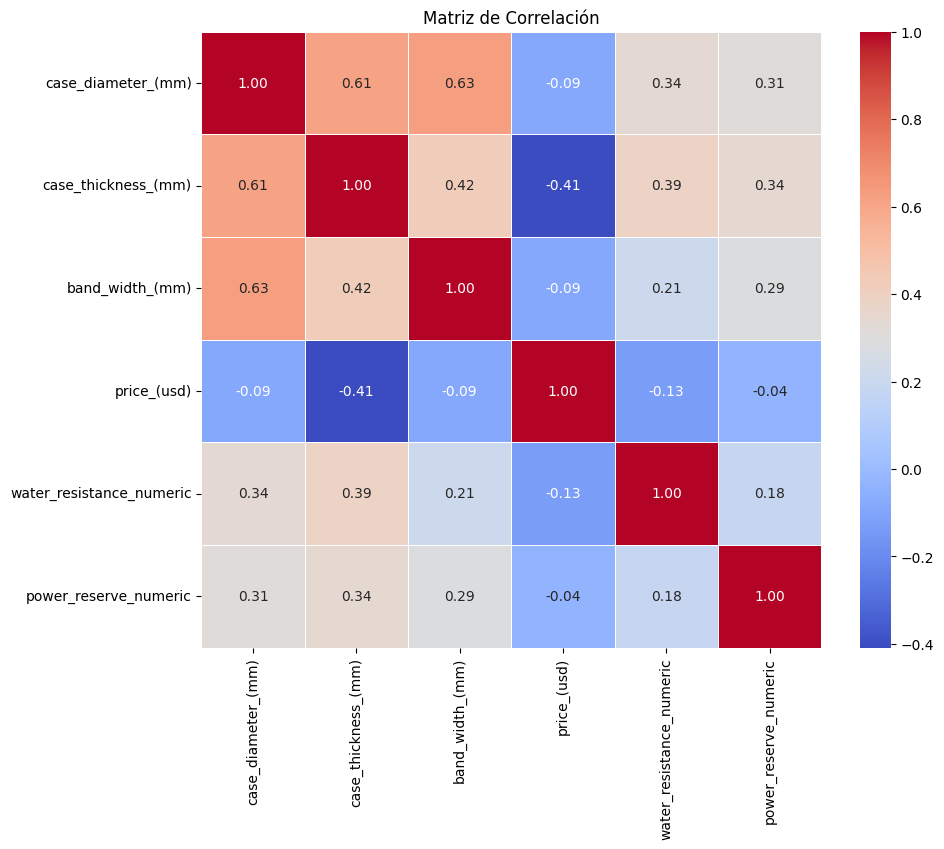

In [23]:
### Análisis de Correlación
import seaborn as sns
import matplotlib.pyplot as plt

# Calcular la matriz de correlación solo con las variables numéricas
correlation_matrix = df[numerical_cols].corr()

# Configurar el tamaño de la figura
plt.figure(figsize=(10, 8))

# Crear el heatmap con anotaciones
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

# Agregar título
plt.title("Matriz de Correlación")

# Mostrar el gráfico
plt.show()




#### Matriz de Correlación Global 

Para entender la relación entre **todas las variables numéricas**, analizamos la **matriz de correlación** y encontramos lo siguiente:  

- **Alta correlación entre variables relacionadas con dimensiones del reloj**:  Esto indica que el tamaño del reloj en general está altamente correlacionado entre sus dimensiones, lo cual es esperable.  
- **Baja correlacion con band_witdth,case_diameter, case_thikness y water _resistence_numeric y power_resitance_numeric** lo que indica ni el ancho de la correa ni el de la caja asi como la resistencia al agua y la autonomía parecen influir directamente en el precio de los relojes de lujo.

#### Conclusiones del Análisis de Correlación

- **No se observa una fuerte correlación entre las variables numéricas y el precio**, lo que indica que el precio de los relojes no depende únicamente de características como tamaño, grosor o resistencia al agua.  
- **Las variables de dimensiones del reloj están altamente correlacionadas entre sí**, lo que podría generar **problemas de multicolinealidad** en modelos predictivos.  
- **Dado que la correlación con el precio es baja, es posible que factores categóricos como la marca, el tipo de movimiento o el material de la caja sean más relevantes para el análisis**.  

  


#### Análisis de la distribucion de las variables numéricas

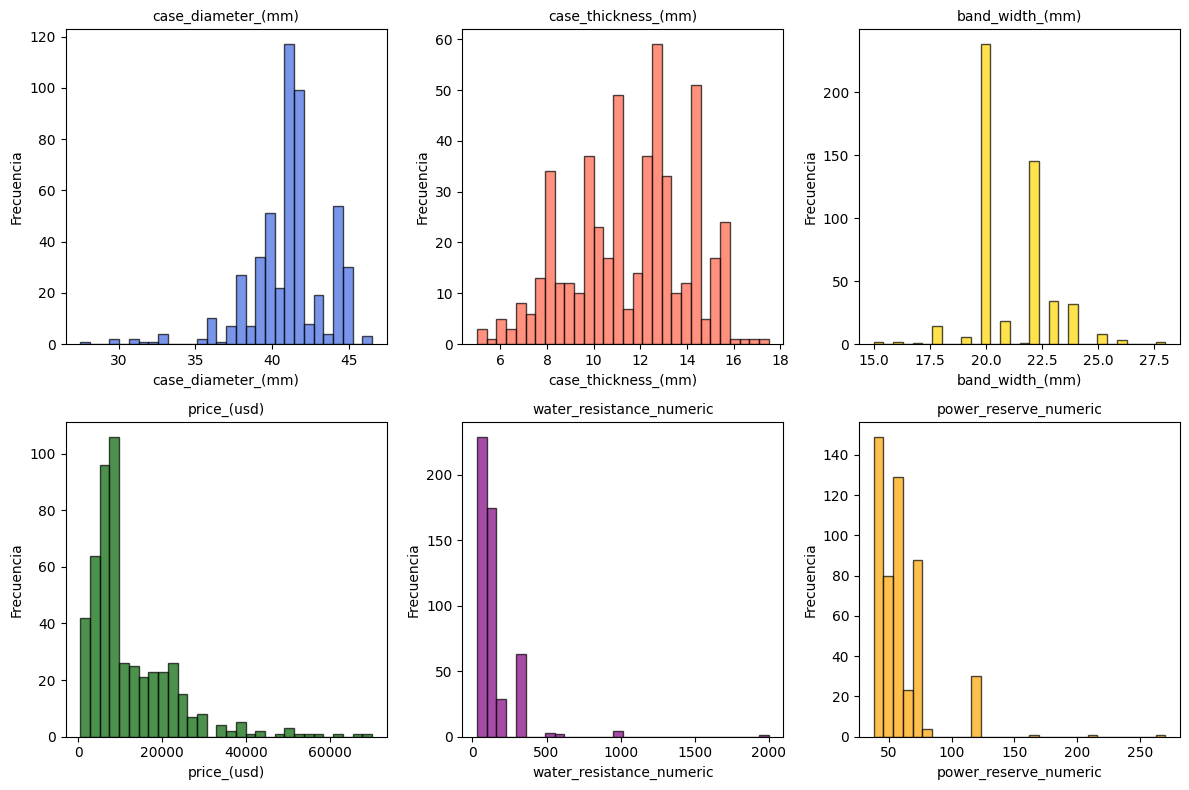

In [24]:
import matplotlib.pyplot as plt

# Definir la paleta de colores
palette = ["royalblue", "tomato", "gold", "darkgreen", "purple", "orange", 
           "crimson", "teal", "darkslategray", "indigo"]

# Seleccionar las variables numéricas
numerical_cols = ['case_diameter_(mm)', 'case_thickness_(mm)',
                  'band_width_(mm)', 'price_(usd)', 'water_resistance_numeric',
                  'power_reserve_numeric']

# Crear histogramas
plt.figure(figsize=(12, 8))
for i, col in enumerate(numerical_cols):
    plt.subplot(2, 3, i + 1)  # Ajustar según el número de variables
    plt.hist(df[col], bins=30, color=palette[i], edgecolor="black", alpha=0.7)
    plt.title(col, fontsize=10)
    plt.xlabel(col)
    plt.ylabel("Frecuencia")

plt.tight_layout()
plt.show()


En el análisis de los histogramas de las variables numéricas, observamos que **case_diameter_(mm)**, **case_thickness_(mm)** y **band_width_(mm)** muestran una distribución que podría tender a la normalidad. Sin embargo, **price_(usd)** y **water_resistance_numeric** claramente no siguen una distribución normal. Por otro lado, **power_reserve_numeric** presenta un sesgo hacia valores bajos, especialmente en cero, pero aún podría ajustarse con transformaciones. En base a esto, se recomienda aplicar una transformación logarítmica a las cuatro variables que no presentan una distribución normal adecuada.


#### Análisis de los outliers en variables numericas 

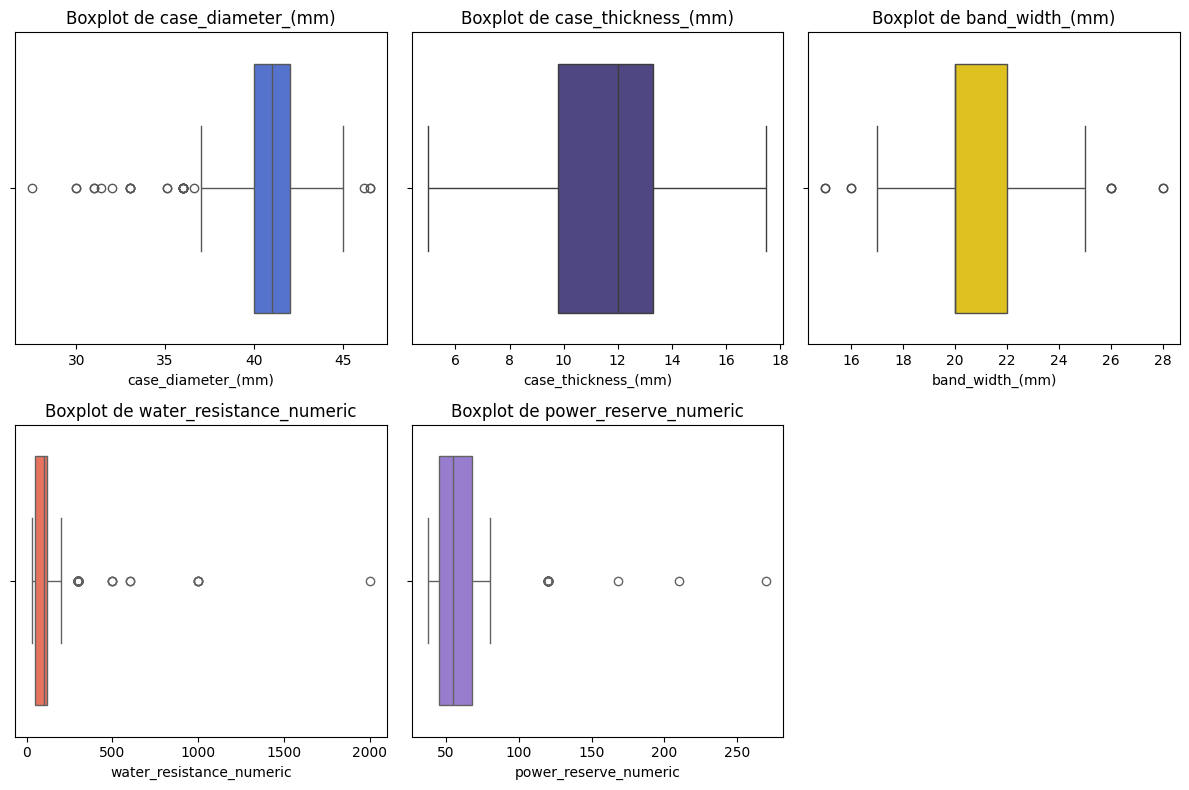

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

# Definir la paleta de colores
luxury_palette = [
    "RoyalBlue", "DarkSlateBlue", "Gold", "Tomato", "MediumPurple", 
    "MediumSeaGreen", "Firebrick", "SteelBlue", "SlateGray", "RosyBrown"
]

# Variables numéricas
numerical_cols = ['case_diameter_(mm)', 'case_thickness_(mm)', 'band_width_(mm)', 
                  'water_resistance_numeric', 'power_reserve_numeric']

# Crear un boxplot para cada variable numérica
plt.figure(figsize=(12, 8))

for i, col in enumerate(numerical_cols, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x=df[col], color=luxury_palette[i-1])  # Utilizando la paleta definida
    plt.title(f'Boxplot de {col}')
    plt.xlabel(col)

plt.tight_layout()
plt.show()


In [26]:
# Redondear la variable antes de detectar outliers
df['case_diameter_(mm)'] = df['case_diameter_(mm)'].round(0)


In [27]:
import pandas as pd

def find_outliers(df, cols):
    outliers_info = {}
    
    for col in cols:
        # Calcular los percentiles y el IQR
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        
        # Definir los límites inferior y superior
        lower_limit = Q1 - 1.5 * IQR
        upper_limit = Q3 + 1.5 * IQR
        
        # Filtrar los outliers
        outliers = df[(df[col] < lower_limit) | (df[col] > upper_limit)]
        
        # Guardar la cantidad de outliers por variable
        outliers_info[col] = outliers.shape[0]  # Número de filas que son outliers
    
    return outliers_info

# Definir las variables numéricas que quieres analizar
numerical_columns = ['case_diameter_(mm)', 'band_width_(mm)', 'water_resistance_numeric', 'power_reserve_numeric']

# Llamar a la función para obtener el número de outliers por variable
outliers = find_outliers(df, numerical_columns)

# Mostrar el número de outliers por cada variable
print(outliers)


{'case_diameter_(mm)': 26, 'band_width_(mm)': 9, 'water_resistance_numeric': 73, 'power_reserve_numeric': 33}


In [28]:
'''# Imputar los outliers con la mediana en las columnas numéricas
for col in numerical_columns:
    # Calcular los percentiles y el IQR
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    
    # Definir los límites inferior y superior
    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR
    
    # Obtener la mediana de la columna
    median_value = df[col].median()
    
    # Reemplazar los outliers con la mediana
    df[col] = df[col].apply(lambda x: median_value if x < lower_limit or x > upper_limit else x)

df.head()'''



'# Imputar los outliers con la mediana en las columnas numéricas\nfor col in numerical_columns:\n    # Calcular los percentiles y el IQR\n    Q1 = df[col].quantile(0.25)\n    Q3 = df[col].quantile(0.75)\n    IQR = Q3 - Q1\n    \n    # Definir los límites inferior y superior\n    lower_limit = Q1 - 1.5 * IQR\n    upper_limit = Q3 + 1.5 * IQR\n    \n    # Obtener la mediana de la columna\n    median_value = df[col].median()\n    \n    # Reemplazar los outliers con la mediana\n    df[col] = df[col].apply(lambda x: median_value if x < lower_limit or x > upper_limit else x)\n\ndf.head()'

In [29]:
'''import numpy as np

# Calcular los límites de outliers nuevamente
Q1 = df['case_diameter_(mm)'].quantile(0.25)
Q3 = df['case_diameter_(mm)'].quantile(0.75)
IQR = Q3 - Q1

# Definir los límites inferior y superior
lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR

# Lista de valores frecuentes dentro del rango más común (39-44)
valores_frecuentes = [39, 40, 41, 42, 43, 44]

# Función para reemplazar los outliers con un valor aleatorio de la lista
def reemplazar_outlier(x):
    if x < lower_limit or x > upper_limit:
        return np.random.choice(valores_frecuentes)
    else:
        return x

# Aplicar la función a la columna
df['case_diameter_(mm)'] = df['case_diameter_(mm)'].apply(reemplazar_outlier)

# Verificar después de la imputación
print(df['case_diameter_(mm)'].value_counts())'''



"import numpy as np\n\n# Calcular los límites de outliers nuevamente\nQ1 = df['case_diameter_(mm)'].quantile(0.25)\nQ3 = df['case_diameter_(mm)'].quantile(0.75)\nIQR = Q3 - Q1\n\n# Definir los límites inferior y superior\nlower_limit = Q1 - 1.5 * IQR\nupper_limit = Q3 + 1.5 * IQR\n\n# Lista de valores frecuentes dentro del rango más común (39-44)\nvalores_frecuentes = [39, 40, 41, 42, 43, 44]\n\n# Función para reemplazar los outliers con un valor aleatorio de la lista\ndef reemplazar_outlier(x):\n    if x < lower_limit or x > upper_limit:\n        return np.random.choice(valores_frecuentes)\n    else:\n        return x\n\n# Aplicar la función a la columna\ndf['case_diameter_(mm)'] = df['case_diameter_(mm)'].apply(reemplazar_outlier)\n\n# Verificar después de la imputación\nprint(df['case_diameter_(mm)'].value_counts())"

In [30]:
'''# Definir la paleta de colores
luxury_palette = [
    "RoyalBlue", "DarkSlateBlue", "Gold", "Tomato", "MediumPurple", 
    "MediumSeaGreen", "Firebrick", "SteelBlue", "SlateGray", "RosyBrown"
]

# Variables numéricas
numerical_cols = ['case_diameter_(mm)', 'case_thickness_(mm)', 'band_width_(mm)', 
                  'water_resistance_numeric', 'power_reserve_numeric']

# Crear un boxplot para cada variable numérica
plt.figure(figsize=(12, 8))

for i, col in enumerate(numerical_cols, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x=df[col], color=luxury_palette[i-1])  # Utilizando la paleta definida
    plt.title(f'Boxplot de {col}')
    plt.xlabel(col)

plt.tight_layout()
plt.show()'''



'# Definir la paleta de colores\nluxury_palette = [\n    "RoyalBlue", "DarkSlateBlue", "Gold", "Tomato", "MediumPurple", \n    "MediumSeaGreen", "Firebrick", "SteelBlue", "SlateGray", "RosyBrown"\n]\n\n# Variables numéricas\nnumerical_cols = [\'case_diameter_(mm)\', \'case_thickness_(mm)\', \'band_width_(mm)\', \n                  \'water_resistance_numeric\', \'power_reserve_numeric\']\n\n# Crear un boxplot para cada variable numérica\nplt.figure(figsize=(12, 8))\n\nfor i, col in enumerate(numerical_cols, 1):\n    plt.subplot(2, 3, i)\n    sns.boxplot(x=df[col], color=luxury_palette[i-1])  # Utilizando la paleta definida\n    plt.title(f\'Boxplot de {col}\')\n    plt.xlabel(col)\n\nplt.tight_layout()\nplt.show()'

##### Conclusión sobre el tratamiento de variables numéricas y outliers 

Tras analizar la distribución de las variables numéricas y detectar la presencia de **outliers**, hemos decidido aplicar una **transformación logarítmica** a dos variables numéricas **power_reserve_numeric y water_resistance_numeric** `band_width_(mm)`.  

Las razones detrás de esta decisión son las siguientes:  

- **`price_(usd)`**, **`water_resistance_numeric`** y **`power_reserve_numeric`** presentan una distribución altamente sesgada y con valores algun valor extremo, lo que puede afectar la estabilidad de los modelos predictivos. La transformación logarítmica ayudará a reducir la asimetría y mejorar la normalidad.  
- **`case_diameter_(mm)`** y **`case_thickness_(mm)`** hemos corregido sus outliers y tienen cierta asimetría en su distribución, por lo que no es necesario transformarla.   
- **`band_width_(mm)`**, en cambio, presenta una distribución más cercana a la normalidad y tiene pocos outliers, por lo que no es necesario transformarla.  

Este proceso nos permitirá mejorar la calidad de los datos para su posterior uso en modelos estadísticos y de machine learning.  


## ANÁLISIS CATEGÓRICO

In [31]:
# Definir las variables categóricas
categorical_vars = ['brand', 'model', 'case_material', 'strap_material', 'movement_type',
       'water_resistance', 'dial_color', 'crystal_material', 'complications',
       'power_reserve']

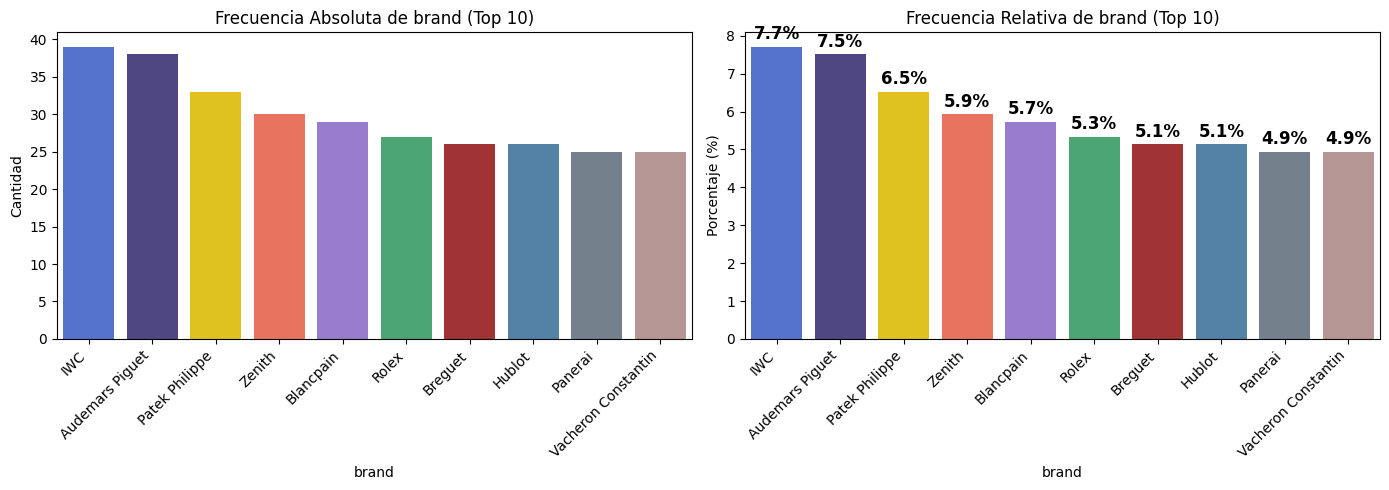

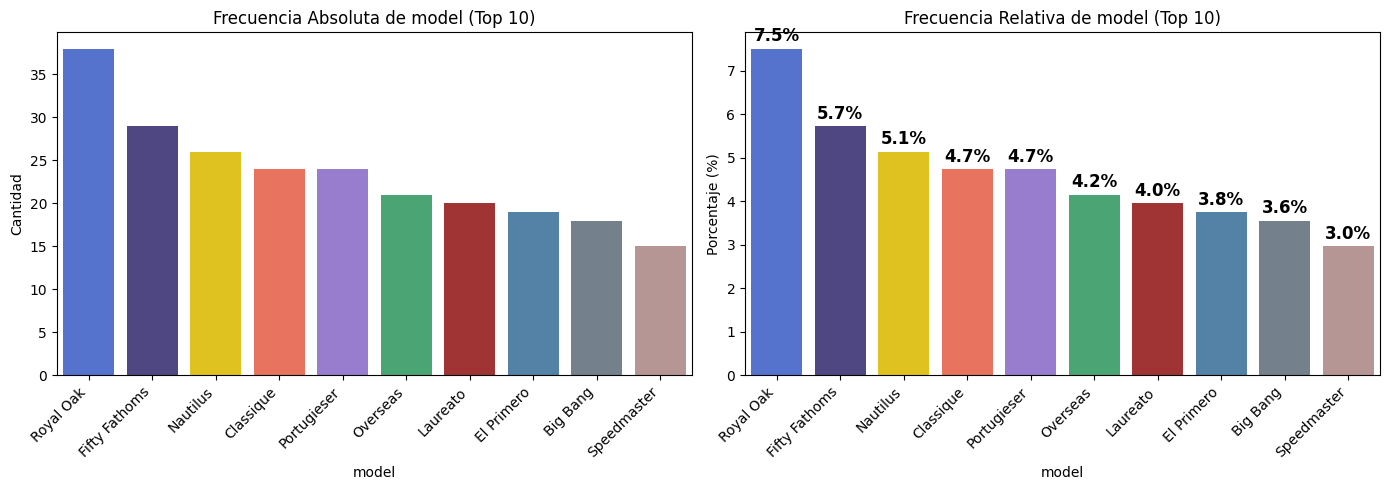

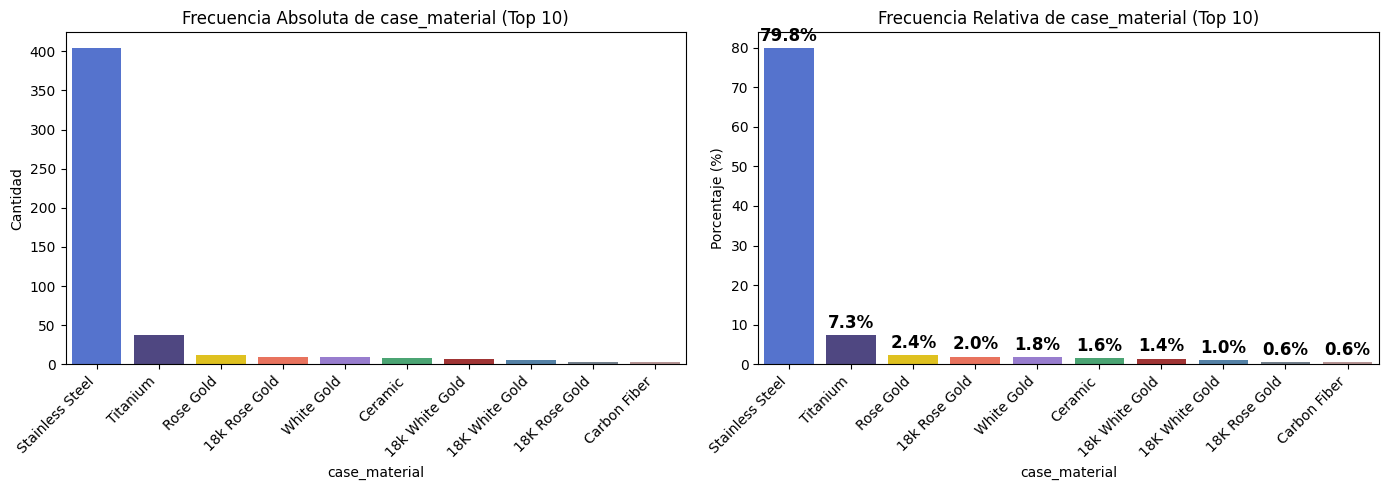

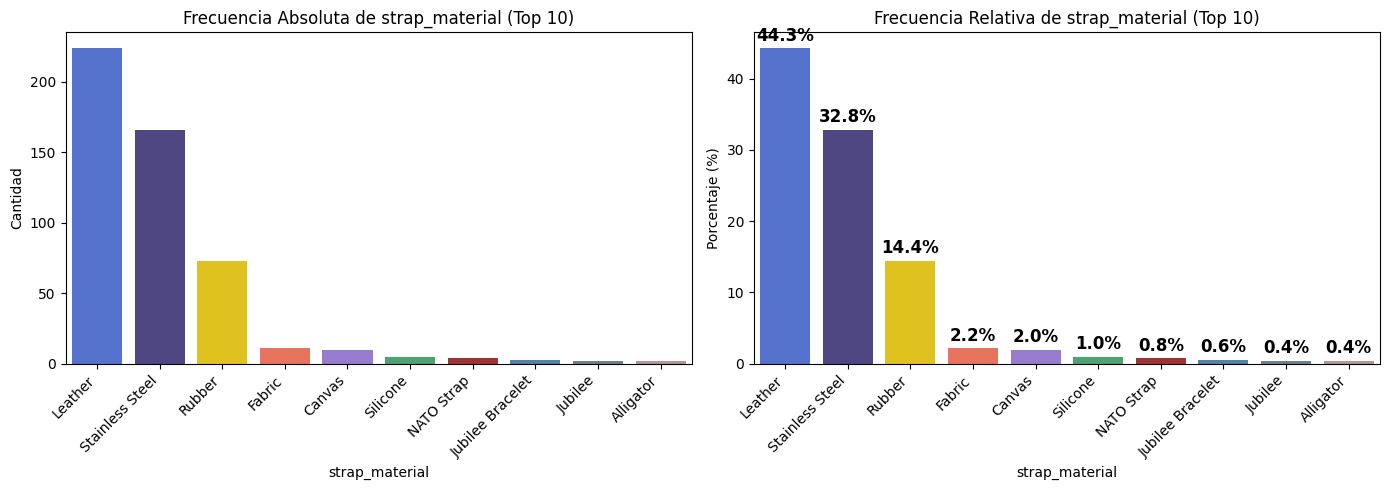

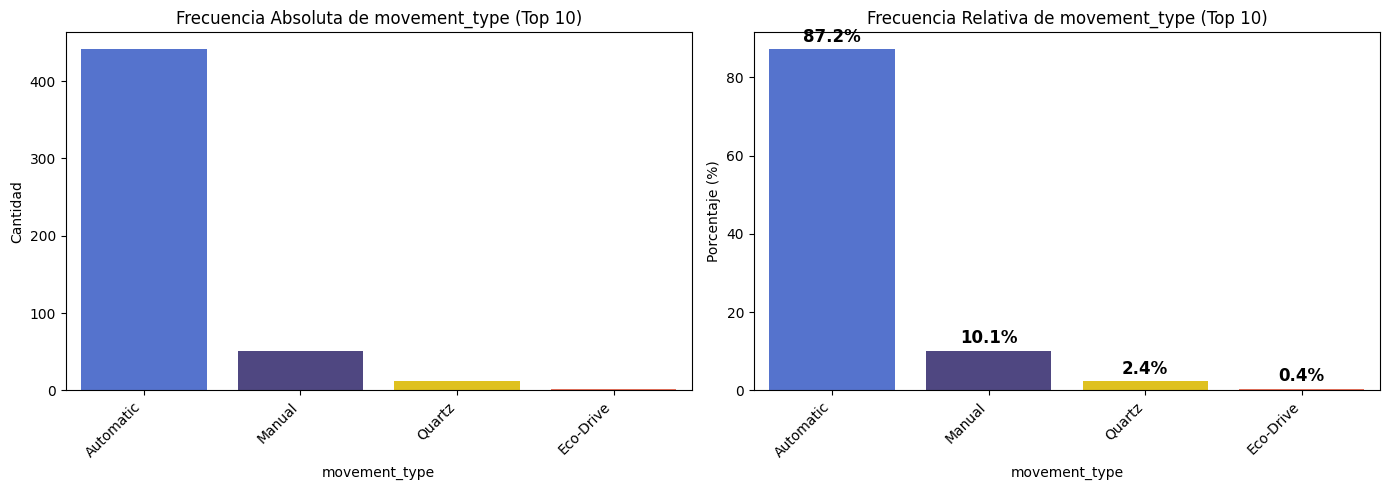

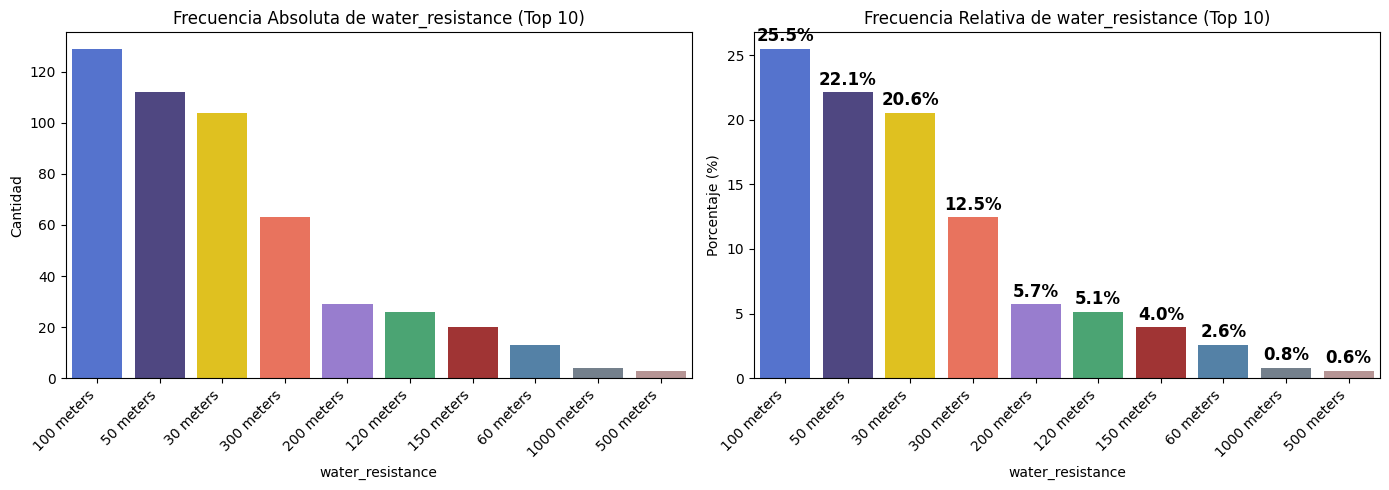

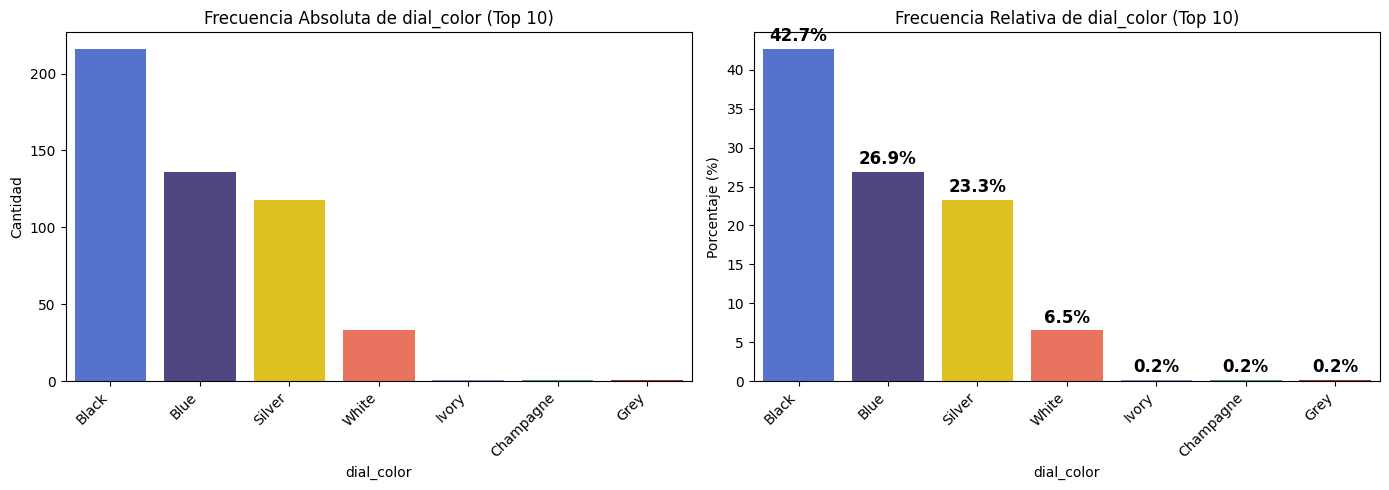

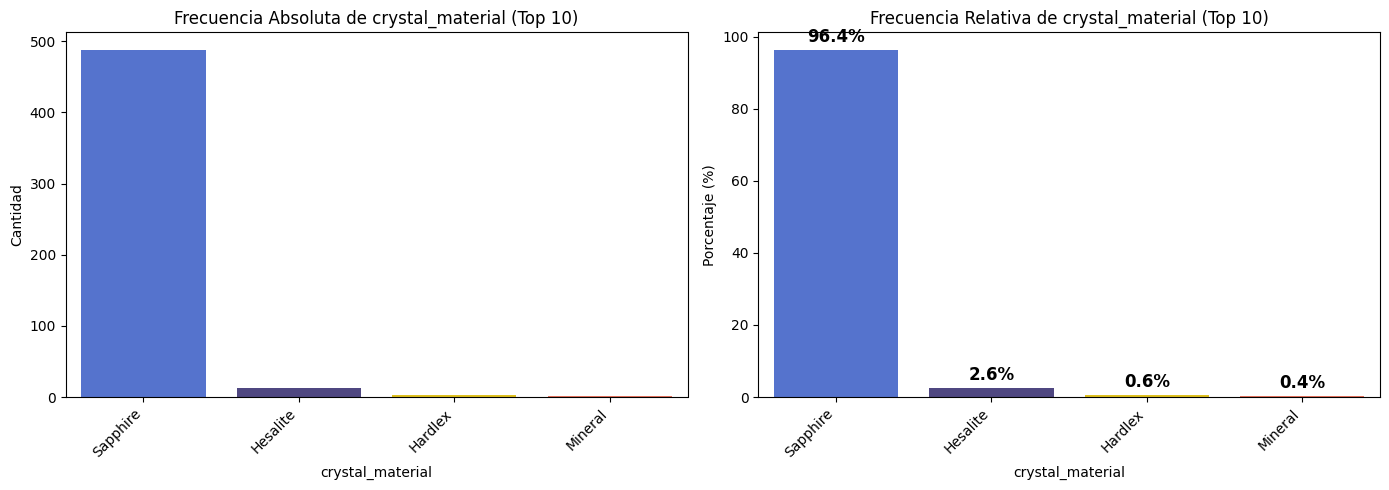

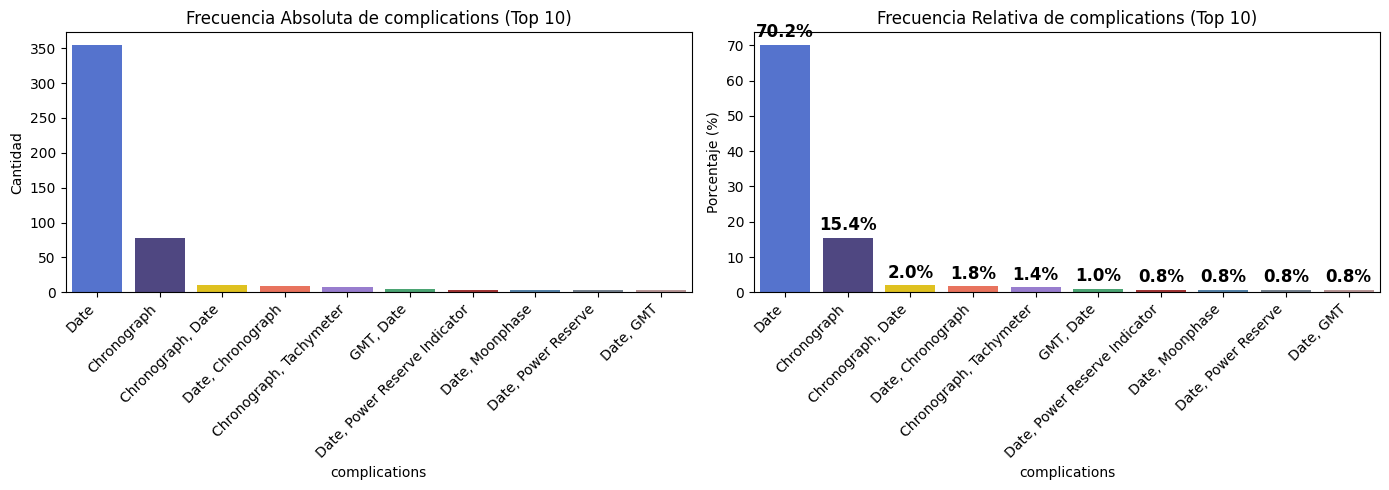

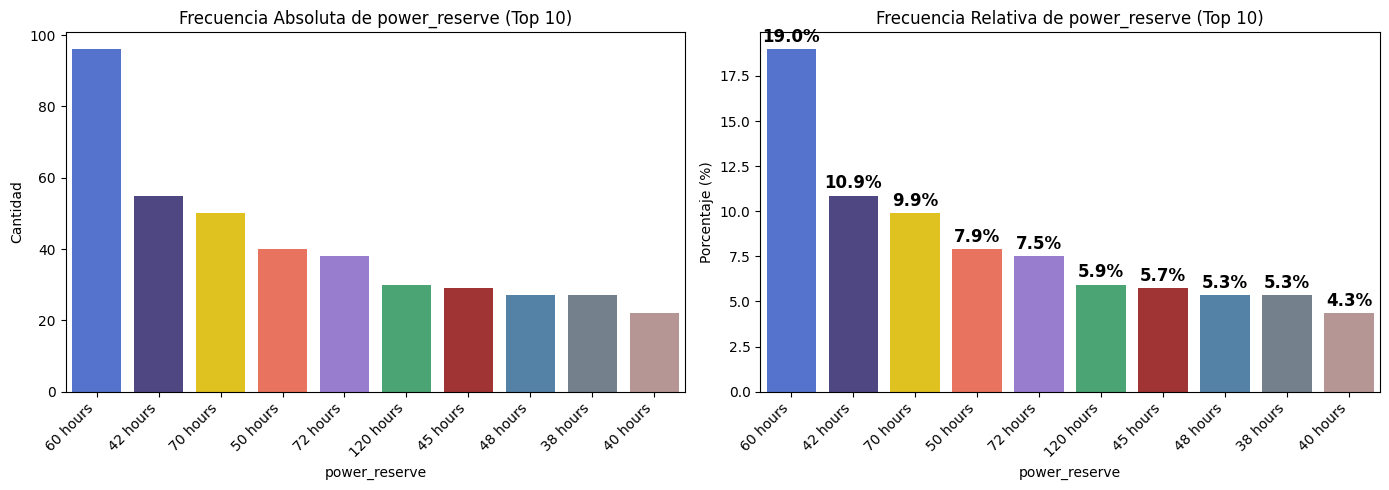

In [32]:

# Función para graficar las 10 categorías más frecuentes en una variable categórica

import matplotlib.pyplot as plt
import seaborn as sns

# Definir la paleta de colores
luxury_palette = [
    "RoyalBlue", "DarkSlateBlue", "Gold", "Tomato", "MediumPurple", 
    "MediumSeaGreen", "Firebrick", "SteelBlue", "SlateGray", "RosyBrown"
]

def plot_categorical_frequencies(df, column_name):
    """
    Grafica la frecuencia absoluta y relativa de las 10 categorías más frecuentes de una variable categórica.

    Args:
    df (DataFrame): DataFrame que contiene los datos.
    column_name (str): Nombre de la columna categórica a analizar.
    """
    # Calcular las 10 categorías más frecuentes
    top_10_absolute_freq = df[column_name].value_counts().nlargest(10)
    top_10_relative_freq = df[column_name].value_counts(normalize=True).nlargest(10) * 100  # Convertir a porcentaje

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))  # Crear dos gráficos en una sola fila

    # Gráfico de frecuencias absolutas
    sns.barplot(x=top_10_absolute_freq.index, y=top_10_absolute_freq.values, palette=luxury_palette, ax=axes[0])
    axes[0].set_title(f'Frecuencia Absoluta de {column_name} (Top 10)')
    axes[0].set_ylabel('Cantidad')
    axes[0].set_xticklabels(top_10_absolute_freq.index, rotation=45, ha='right')

    # Gráfico de frecuencias relativas
    sns.barplot(x=top_10_relative_freq.index, y=top_10_relative_freq.values, palette=luxury_palette, ax=axes[1])
    axes[1].set_title(f'Frecuencia Relativa de {column_name} (Top 10)')
    axes[1].set_ylabel('Porcentaje (%)')
    axes[1].set_xticklabels(top_10_relative_freq.index, rotation=45, ha='right')
     # Añadir los porcentajes encima de cada barra
    for p in axes[1].patches:
        axes[1].annotate(f'{p.get_height():.1f}%', 
                         (p.get_x() + p.get_width() / 2., p.get_height()), 
                         ha='center', va='center', 
                         xytext=(0, 9), textcoords='offset points', 
                         fontsize=12, color='black', fontweight='bold')

    plt.tight_layout()
    plt.show()

# Lista de variables categóricas
categorical_vars = ['brand', 'model', 'case_material', 'strap_material', 'movement_type',
                    'water_resistance', 'dial_color', 'crystal_material', 'complications',
                    'power_reserve']

# Generar los gráficos para cada variable categórica
for var in categorical_vars:
    plot_categorical_frequencies(df, var)



#####  Conclusiones analisis frecuencias relativas y absolutas de las variables categoricas

- **Marca:** Hay una buena representación de marcas, siendo Patek Philippe, Hublot, Zenith y BlackPain las más frecuentes, con valores cercanos al 8%. Aunque no hay una marca dominante, hay mucha diversidad.
  
- **Modelo:** El modelo más frecuente es Royal Oak, con un 7%, seguido de otros modelos icónicos. Aunque hay una variedad de modelos, los más conocidos y representativos predominan moderadamente.

- **Material del reloj:** Stainless Steel es el material más común, con una amplia diferencia frente a Titanium (7%). Esto muestra una fuerte preferencia por el acero inoxidable.

- **Material de la correa:** Leder (cuero) es el material más frecuente para las correas, seguido de Stainless Steel y Rubber. El cuero es claramente el material más utilizado, pero con otras opciones también presentes.

- **Tipo de movimiento:** Automático domina con un 90%, siendo ampliamente preferido en relojes de lujo. Los otros tipos de movimiento, como manual o cuarto, tienen una representación mínima.

- **Resistencia al agua:** La mayoría de los relojes tienen una resistencia al agua de 100 metros, seguida de los de 50 y 30 metros. Esto refleja una preferencia por relojes con resistencia moderada al agua.

- **Color de la esfera:** El color más común es negro, seguido de azul y plata. Los colores más clásicos dominan, con el negro siendo la opción preferida.

- **Cristal:** El cristal de zafiro es el más utilizado, representando el 96% de los relojes. Esto refleja la alta calidad y durabilidad de los cristales de zafiro en los relojes de lujo.

- **Complicaciones:** La mayoría de los relojes tienen la complicación de "fecha", seguida por el cronógrafo. La complicación de "fecha" es claramente la más popular.

- **Reserva de marcha:** Los relojes con 60 horas de reserva de marcha son los más comunes, seguidos de aquellos con 11 y 70 horas. La mayoría de los relojes tiene una reserva de marcha moderada.


In [33]:
categorical_vars = [
    'brand', 'model', 'case_material', 'strap_material', 'movement_type',
    'water_resistance', 'dial_color', 'crystal_material', 'complications',
    'power_reserve'
]

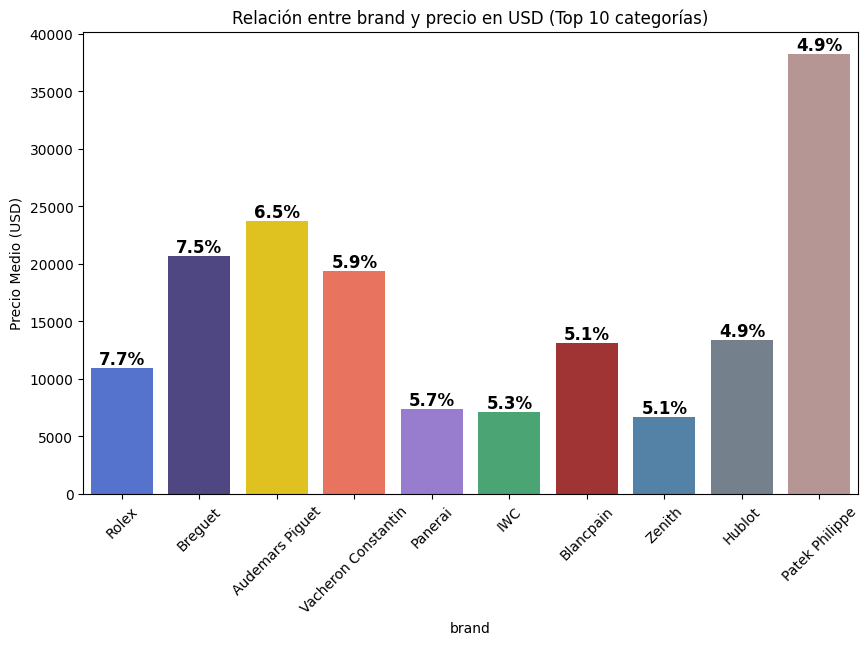

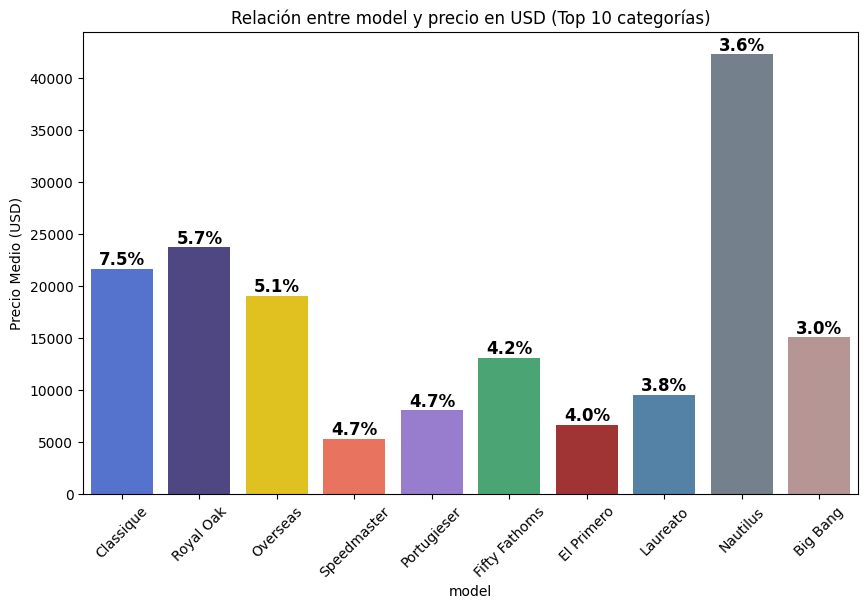

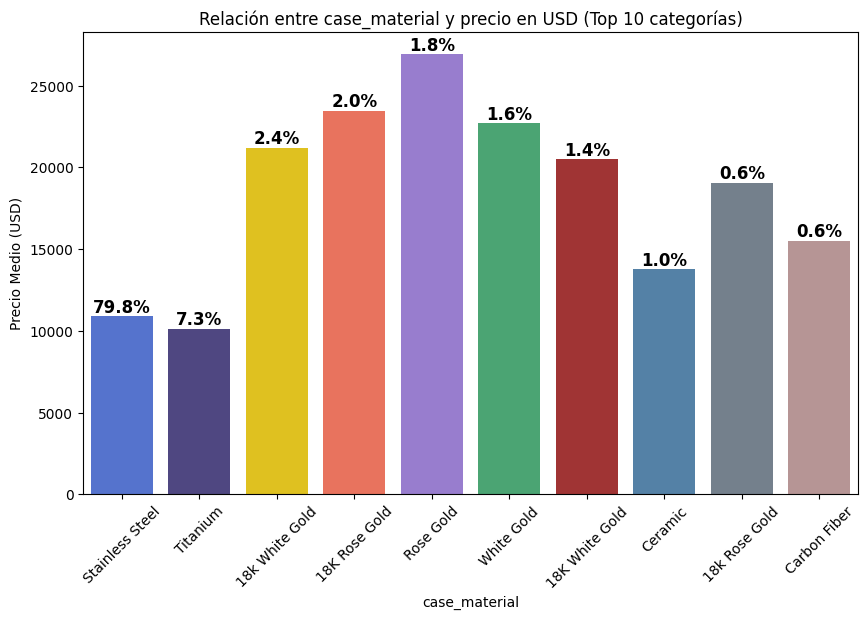

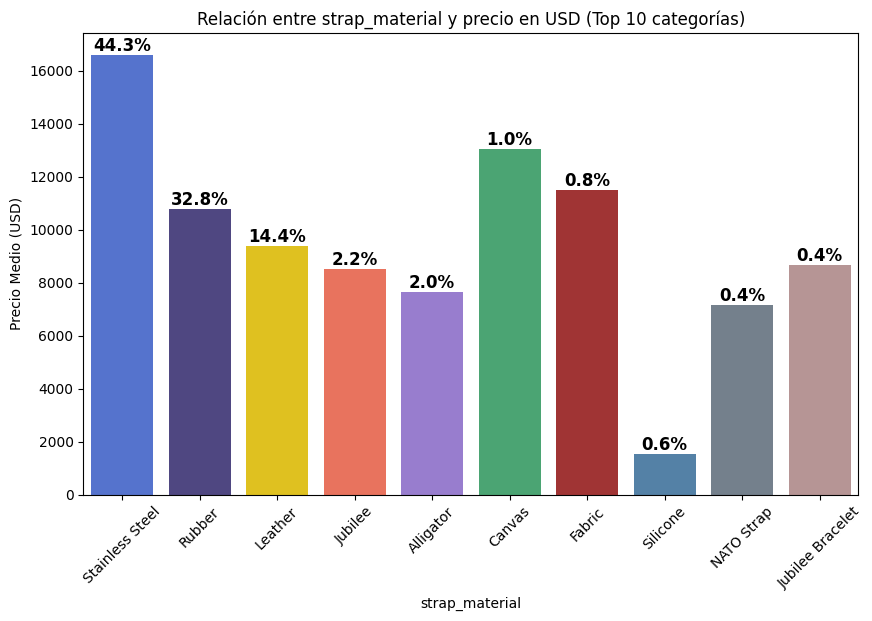

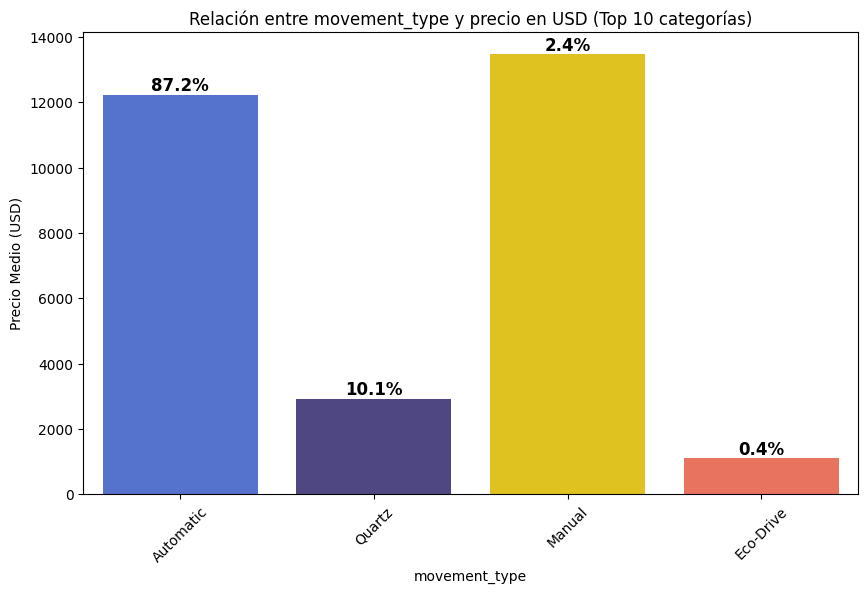

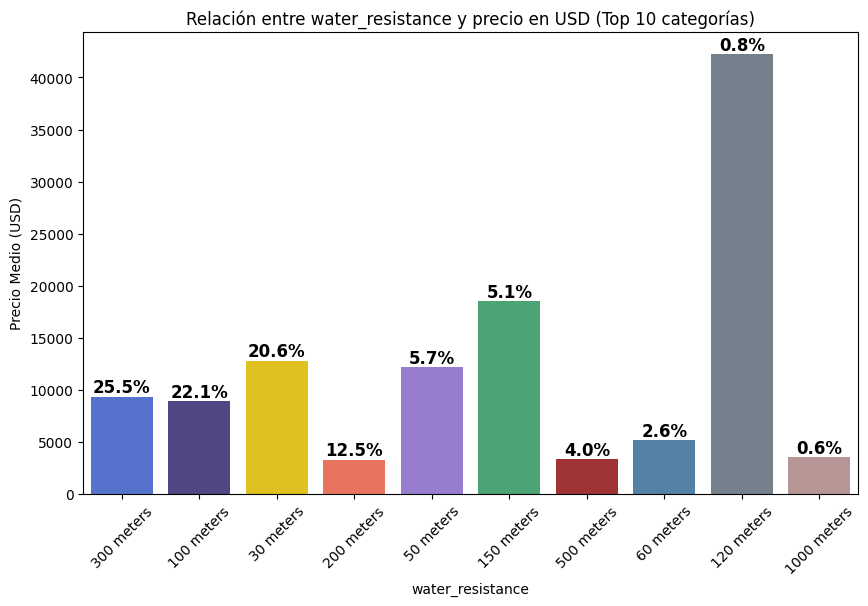

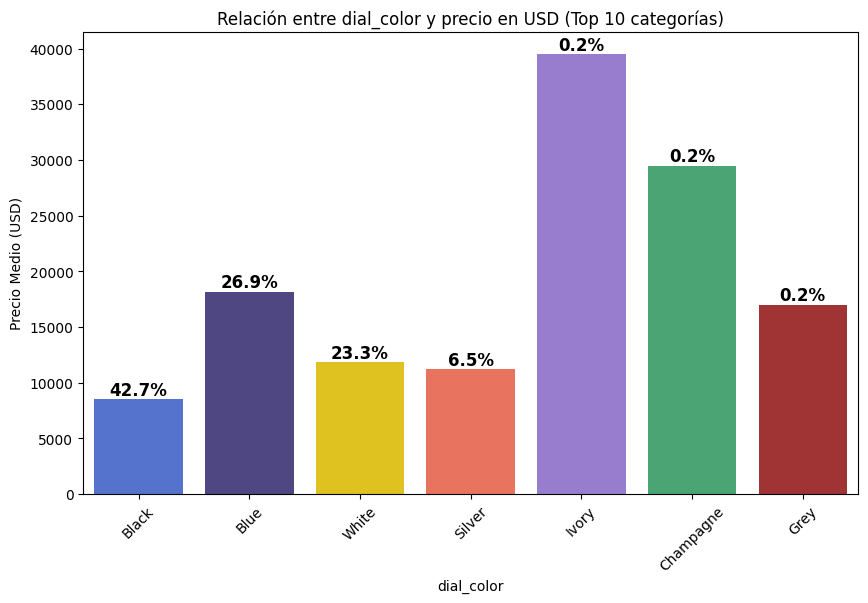

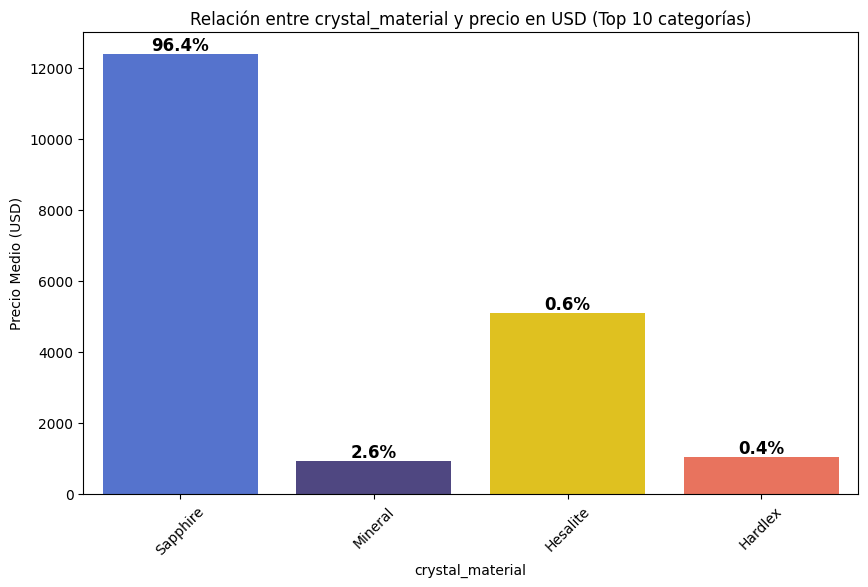

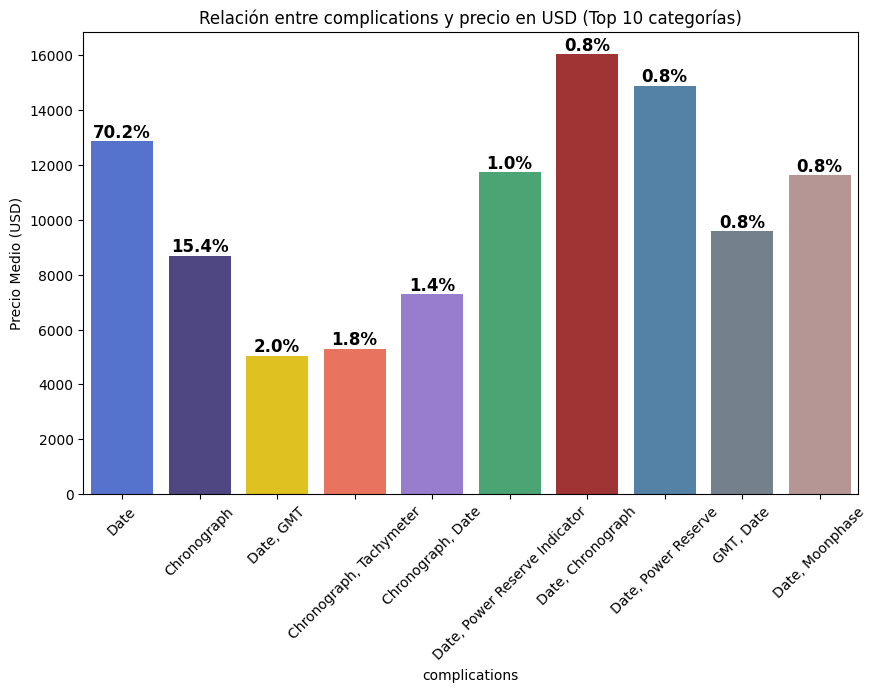

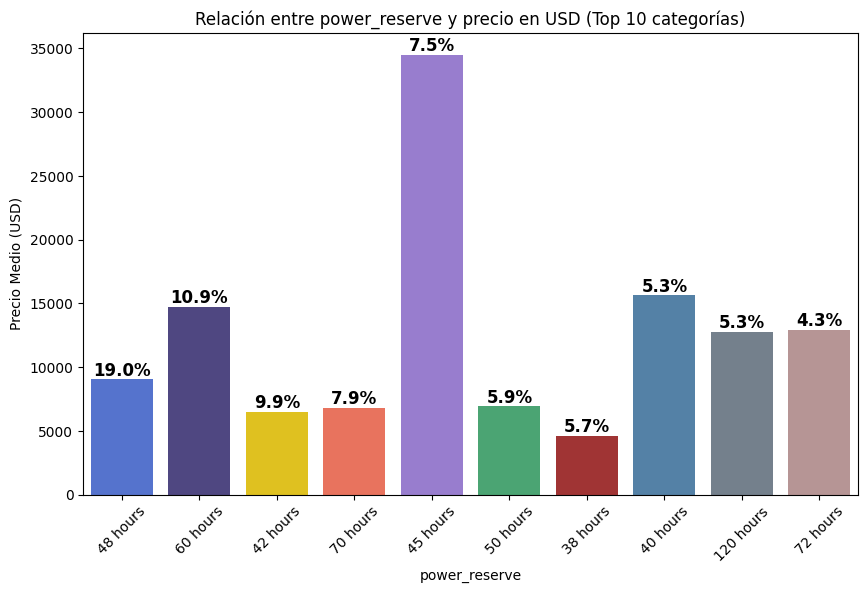

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

# Función para graficar las 10 categorías más frecuentes con porcentajes
def plot_top_10_categories(df, column_name):
    # Obtener las 10 categorías más frecuentes con sus conteos
    top_10_counts = df[column_name].value_counts().nlargest(10)
    top_10 = top_10_counts.index

    # Calcular porcentajes
    total_count = df[column_name].value_counts().sum()
    top_10_percentages = (top_10_counts/total_count)*100

    # Filtrar el dataset para que solo contenga esos 10 valores más frecuentes
    df_filtered = df[df[column_name].isin(top_10)]
    
    # Definir la paleta de colores de lujo
    luxury_palette = [
        "RoyalBlue", "DarkSlateBlue", "Gold", "Tomato", "MediumPurple", 
        "MediumSeaGreen", "Firebrick", "SteelBlue", "SlateGray", "RosyBrown"
    ]
    
    # Crear la figura
    plt.figure(figsize=(10, 6))
    
    # Graficar el precio medio de cada categoría
    ax = sns.barplot(
        x=column_name, 
        y='price_(usd)', 
        data=df_filtered, 
        estimator='mean', 
        ci=None, 
        palette=luxury_palette
    )
    
    # Agregar los porcentajes como etiquetas en cada barra
    for i, p in enumerate(ax.patches):
        ax.annotate(
            f"{top_10_percentages.iloc[i]:.1f}%", 
            (p.get_x() + p.get_width() / 2, p.get_height()), 
            ha='center', va='bottom', fontsize=12, fontweight='bold', color='black'
        )
    
    # Ajustes de formato
    plt.xticks(rotation=45)
    plt.title(f'Relación entre {column_name} y precio en USD (Top 10 categorías)')
    plt.ylabel('Precio Medio (USD)')
    plt.xlabel(column_name)
    plt.show()

# Graficar las 10 categorías más frecuentes de cada variable categórica
categorical_vars = [
    'brand', 'model', 'case_material', 'strap_material', 'movement_type',
    'water_resistance', 'dial_color', 'crystal_material', 'complications',
    'power_reserve'
]

for var in categorical_vars:
    plot_top_10_categories(df, var)


##### Conclusión sobre el análisis inicial de variables categóricas con el precio

Tras analizar la relación entre las variables categóricas y el precio, hemos obtenido las siguientes conclusiones clave:  

- **Marca:** La marca más cara es `Patek Philippe`, seguida por `Audemars Piguet`, `Breguet` y `Vacheron Constantin`.  
- **Modelo:** Los modelos más costosos son `Nautilus`, `Royal Oak`, `Classic` y `Overseas`.  
- **Material de la caja:** Los relojes de `Titanio`, `Oro Rosa` y `Oro de 18k` son los más caros, con `Oro Blanco` y `Stainless Steel` en un rango similar.  
- **Material de la correa:** El `Nato Strap` es significativamente más caro que el resto, seguido de `Silicone`.  
- **Tipo de movimiento:** Los relojes manuales ` son mucho más costosos que los de `Quartz`, `Automatic` y `Eco`.  
- **Resistencia al agua:** No existe una relación clara entre la resistencia al agua y el precio, ya que los más caros son los de `200m`, seguidos de `120m` y `30m`, mientras que los de `300m` no destacan en precio.  
- **Color del dial:** Los más costosos son los de color `Ivory`, `Blanco` y `Champagne`, indicando una clara preferencia en relojería de lujo.  
- **Material del cristal:**  lo esperado, los relojes con cristal `Zafiro` son los más caros, seguidos de `Hesalite`, mientras que `Mineral` y `Hardlex` son más asequibles.  
- **Complicaciones:** La función `Cronograph` es la más costosa, seguida de `Date`, mientras que el resto de combinaciones de complicaciones tienen un menor impacto en el precio.  
- **Autonomia:** Los relojes con 45 horas de reserva de energía son los más caros, seguidos de los de 60 horas, sin una relación clara con los de mayor duración.  

Este análisis nos permite identificar patrones de precios en función de características específicas, destacando aquellas que tienen un impacto significativo y otras que no muestran una correlación evidente.

#### Conclusiones Finales variables categoricas:

Tras analizar las variables categóricas tanto por sus frecuencias absolutas y relativas como por su relación con el precio, hemos llegado a algunas conclusiones clave. Primero, entendemos qeu se podrian eliminar variables como la **resistencia al agua** y la **autonomia**, ya que no muestran una relación significativa con el precio. En cuanto a los **colores de la esfera**, los más representativos en los relojes de lujo son el **negro, azul y plata**, que también están alineados con las preferencias de los consumidores de lujo. Respecto a las **marcas**, **Patek Philippe**, **Audemars Piguet** y **Breguet** se destacan, siendo las más caras, mientras que en **modelos**, el **Nautilus** y el **Royal Oak** son los más caros y emblemáticos. El **material del casco** de **Stainless Steel** es el más común, seguido por el **oro rosa y titanio**, que también se asocian a precios elevados. Las **correas de cuero** son las más utilizadas, seguidas por las de **acero inoxidable**, mientras que las de **silicona** y **Nato** muestran diferencias de precios en relación con su material. En cuanto a las **complicaciones**, los relojes con **cronógrafo** y **fecha** tienden a ser más caros. Finalmente, las variables con mayor relevancia para predecir el precio incluyen la **marca**, **modelo**, **material del caso**, **correa**, **complicaciones** y **movimiento**, mientras que otras como **resistencia al agua** y **autonomia** parecen tener una influencia marginal.


In [35]:
# Hallar la cardinalidad de cada variable categórica y ordenarlas
categorical_vars = [
    'brand', 'model', 'case_material', 'strap_material', 'movement_type',
    'water_resistance', 'dial_color', 'crystal_material', 'complications',
    'power_reserve'
]

# Crear un diccionario para almacenar la cardinalidad y su porcentaje
cardinality_dict = {}

# Calcular la cardinalidad para cada variable categórica
for col in categorical_vars:
    cardinality = df[col].nunique()  # Valores únicos
    total = len(df[col])  # Total de elementos en la columna
    cardinality_percentage = (cardinality / total) * 100  # Porcentaje respecto al total
    cardinality_dict[col] = (cardinality, cardinality_percentage)

# Ordenar por cardinalidad de mayor a menor
sorted_cardinality = sorted(cardinality_dict.items(), key=lambda x: x[1][0], reverse=True)

# Imprimir los resultados ordenados
print("\nCardinalidad de las variables categóricas (ordenadas de mayor a menor):")
for col, (card, perc) in sorted_cardinality:
    print(f"{col}: {card} valores únicos ({perc:.2f}%)")



Cardinalidad de las variables categóricas (ordenadas de mayor a menor):
model: 95 valores únicos (18.77%)
brand: 39 valores únicos (7.71%)
complications: 29 valores únicos (5.73%)
power_reserve: 24 valores únicos (4.74%)
case_material: 17 valores únicos (3.36%)
strap_material: 14 valores únicos (2.77%)
water_resistance: 12 valores únicos (2.37%)
dial_color: 7 valores únicos (1.38%)
movement_type: 4 valores únicos (0.79%)
crystal_material: 4 valores únicos (0.79%)


In [36]:
criterio=3

# Filtrar las variables categóricas que cumplen el criterio
categoricas_principales = [col for col, (card, perc) in sorted_cardinality if perc > criterio]

'''# Imprimir los resultados ordenados
print("\nCardinalidad de las variables categóricas (ordenadas de mayor a menor):")
for col, (card, perc) in sorted_cardinality:
    print(f"{col}: {card} valores únicos ({perc:.2f}%)")'''

# Imprimir las variables categóricas principales
print("\nVariables categóricas con cardinalidad > 3%:")
print(categoricas_principales)



Variables categóricas con cardinalidad > 3%:
['model', 'brand', 'complications', 'power_reserve', 'case_material']


In [37]:
import pandas as pd
import scipy.stats as stats
from itertools import combinations

# Lista de variables categóricas a analizar
categorical_vars = ['model', 'brand', 'complications', 'power_reserve', 'case_material']

# Lista para almacenar los resultados
chi2_results = []

# Prueba de Chi-Cuadrado para cada par de variables categóricas
for var1, var2 in combinations(categorical_vars, 2):
    # Crear tabla de contingencia
    contingency_table = pd.crosstab(df[var1], df[var2])

    # Aplicar la prueba de Chi-Cuadrado
    chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

    # Guardar resultados en la lista
    chi2_results.append({'Variable 1': var1, 'Variable 2': var2, 'Chi2': chi2, 'p-valor': p})

# Convertir los resultados en un DataFrame y ordenarlos por p-valor ascendente
chi2_results_df = pd.DataFrame(chi2_results).sort_values(by='p-valor')

# Mostrar los resultados ordenados
print("\nResultados de la prueba de Chi-Cuadrado:")
chi2_results_df



Resultados de la prueba de Chi-Cuadrado:


,Variable 1,Variable 2,Chi2,p-valor
0,model,brand,18241.464286,0.000000e+00
2,model,power_reserve,7090.980359,0.000000e+00
5,brand,power_reserve,5616.886473,0.000000e+00
6,brand,case_material,1664.601053,4.483915e-99
3,model,case_material,2903.268660,1.400592e-91
7,complications,power_reserve,1151.010122,3.608316e-31
1,model,complications,3277.984835,6.507433e-17
9,power_reserve,case_material,580.897290,8.782608e-12
4,brand,complications,1240.574037,1.318135e-04
8,complications,case_material,180.947941,1.000000e+00


##### 📌 Conclusiones de la prueba de Chi-Cuadrado  

Hemos realizado una **prueba de Chi-Cuadrado** para evaluar la relación entre variables categóricas con alta cardinalidad. Este test mide si hay dependencia entre las categorías de cada variable.  

Los resultados indican que existe una relación significativa entre **model y brand** (p < 0.05), lo que sugiere que ciertas marcas fabrican modelos específicos. También hay una fuerte dependencia entre **model y power_reserve**, lo que indica que la  autonomia del reloj varía según el modelo.  

Por otro lado, la relación entre **complications y case_material** no es significativa (p = 1.0), lo que sugiere que el material del reloj no está directamente vinculado a sus complicaciones. En general, las variables **brand, model, case_material y power_reserve** presentan relaciones importantes que podrían influir en el precio. 🚀


In [38]:
import scipy.stats as stats

# Función para realizar la prueba de Kruskal-Wallis entre una variable categórica y la variable target (precio)
def kruskal_wallis_test(df, target, categorical_vars):
    results = []
    
    for col in categorical_vars:
        # Agrupar los datos por las categorías de la variable
        groups = [df[target][df[col] == category] for category in df[col].unique()]
        
        # Realizar la prueba de Kruskal-Wallis
        H, p_value = stats.kruskal(*groups)
        
        # Almacenar el resultado
        results.append((col, H, p_value))
    
    return results

# Variables categóricas para probar
categorical_vars = ['model', 'brand', 'complications', 'power_reserve', 'case_material']

# Realizar la prueba de Kruskal-Wallis
kruskal_results = kruskal_wallis_test(df, 'price_(usd)', categorical_vars)

# Imprimir los resultados
print("\nResultados de la prueba de Kruskal-Wallis:")
for col, H, p_value in kruskal_results:
    print(f"{col}: H = {H:.2f}, p-valor = {p_value:.4e}")



Resultados de la prueba de Kruskal-Wallis:
model: H = 476.94, p-valor = 1.4042e-52
brand: H = 449.00, p-valor = 1.1299e-71
complications: H = 42.24, p-valor = 4.1129e-02
power_reserve: H = 250.78, p-valor = 3.4523e-40
case_material: H = 97.31, p-valor = 1.1019e-13


##### Conclusiones del Análisis de Kruskal-Wallis

Hemos utilizado la prueba de **Kruskal-Wallis** para analizar la relación que pueden tener las variables categóricas con nuestra variable objetivo (precio). Dado que estamos interesados en variables con alta cardinalidad, nos centramos en las siguientes variables: **model**, **brand**, **complications**, **power_reserve** y **case_material**.

Los resultados de la prueba indican que **model**, **brand**, **power_reserve** y **case_material** tienen una relación significativa con el precio, con valores p extremadamente bajos. Esto sugiere que estas variables son factores importantes a considerar al predecir el precio de los relojes.

Por otro lado, la variable **complications** también muestra un impacto sobre el precio, pero en menor medida, ya que su valor p es más alto en comparación con las otras variables.

En resumen, **model**, **brand**, **power_reserve** y **case_material** son variables claves para predecir el precio, mientras que **complications** tiene un impacto más moderado.


In [39]:
import pandas as pd

# Tabla de contingencia para 'model' y 'brand' con el precio
crosstab_model_brand = pd.crosstab([df['model'], df['brand']], df['price_(usd)'], dropna=False)

# Mostrar los primeros 10 resultados de la tabla de contingencia de 'model' y 'brand'
print("Tabla de contingencia para Model y Brand con el precio:")
crosstab_model_brand.head(10)

# Tabla de contingencia para 'case_material' y 'power_reserve' con el precio
crosstab_case_material_power_reserve = pd.crosstab([df['case_material'], df['power_reserve']], df['price_(usd)'], dropna=False)
crosstab_case_material_power_reserve.head(10)


Tabla de contingencia para Model y Brand con el precio:


price_(usd)                  495    545    595    650    995    1150   1200   \
case_material power_reserve                                                    
18K Rose Gold 120 hours          0      0      0      0      0      0      0   
              168 hours          0      0      0      0      0      0      0   
              210 days           0      0      0      0      0      0      0   
              270 days           0      0      0      0      0      0      0   
              38 hours           0      0      0      0      0      0      0   
              40 hours           0      0      0      0      0      0      0   
              41 hours           0      0      0      0      0      0      0   
              42 hours           0      0      0      0      0      0      0   
              43 hours           0      0      0      0      0      0      0   
              44 hours           0      0      0      0      0      0      0   

price_(usd)                  1300   1400   1500   ...  44500  47000  49800  \
case_material power_reserve                       ...                        
18K Rose Gold 120 hours          0      0      0  ...      0      0      0   
              168 hours          0      0      0  ...      0      0      0   
              210 days           0      0      0  ...      0      0      0   
              270 days           0      0      0  ...      0      0      0   
              38 hours           0      0      0  ...      0      0      0   
              40 hours           0      0      0  ...      0      0      0   
              41 hours           0      0      0  ...      0      0      0   
              42 hours           0      0      0  ...      0      0      0   
              43 hours           0      0      0  ...      0      0      0   
              44 hours           0      0      0  ...      0      0      0   

price_(usd)                  51000  52000  55000  57000  62500  67000  70000  
case_material power_reserve                                                   
18K Rose Gold 120 hours          0      0      0      0      0      0      0  
              168 hours          0      0      0      0      0      0      0  
              210 days           0      0      0      0      0      0      0  
              270 days           0      0      0      0      0      0      0  
              38 hours           0      0      0      0      0      0      0  
              40 hours           0      0      0      0      0      0      0  
              41 hours           0      0      0      0      0      0      0  
              42 hours           0      0      0      0      0      0      0  
              43 hours           0      0      0      0      0      0      0  
              44 hours           0      0      0      0      0      0      0  

[10 rows x 182 columns]

### ANALISIS MULTIVARIANTE

##### Análisis multivariante: Relación entre Precio, Marca y Modelo

**Objetivo del análisis**:
Realizamos un análisis multivariante para examinar la relación entre **precio**, **marca** y **modelo**. Este análisis tiene como objetivo identificar qué marcas y modelos tienen un precio más alto y si existe alguna relación significativa entre ellos.

**Métodos utilizados**:
1. Filtramos las 10 marcas más frecuentes y los 10 modelos más populares.
2. Creamos un gráfico de barras donde se muestra la relación entre marca, modelo y precio.

**Conclusiones**:
- **Patek Philippe** es la marca más cara, seguida de **Audemars Piguet**, **Breguet** y **Bacheron Constantin**.
- El **modelo Nautilus** de Patek Philippe es el más caro, seguido por el **Royal Oak** de Audemars Piguet y el **Clásique** de Breguet.
- Los modelos más caros están asociados a marcas de lujo, lo que refuerza la idea de que la marca y el modelo tienen una relación directa con el precio.

Este análisis nos proporciona información valiosa sobre cómo las marcas y los modelos más representativos se distribuyen en relación al precio de los relojes.


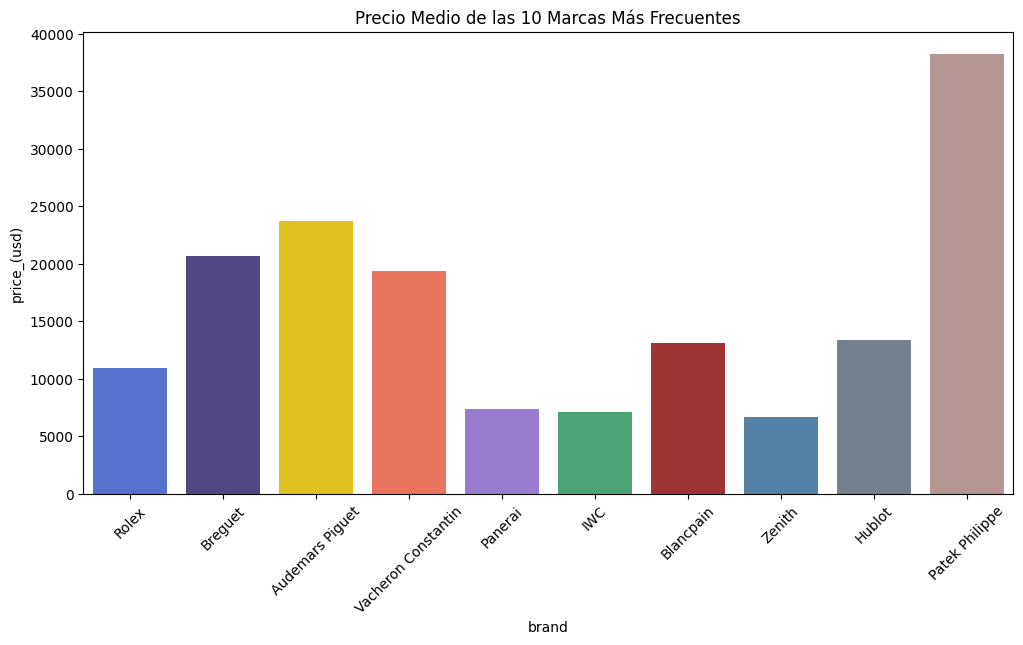

In [40]:
top_brands = df['brand'].value_counts().nlargest(10).index
df_filtered = df[df['brand'].isin(top_brands)]

plt.figure(figsize=(12, 6))
sns.barplot(x='brand', y='price_(usd)', data=df_filtered, ci=None, palette=luxury_palette)
plt.xticks(rotation=45)
plt.title("Precio Medio de las 10 Marcas Más Frecuentes")
plt.show()



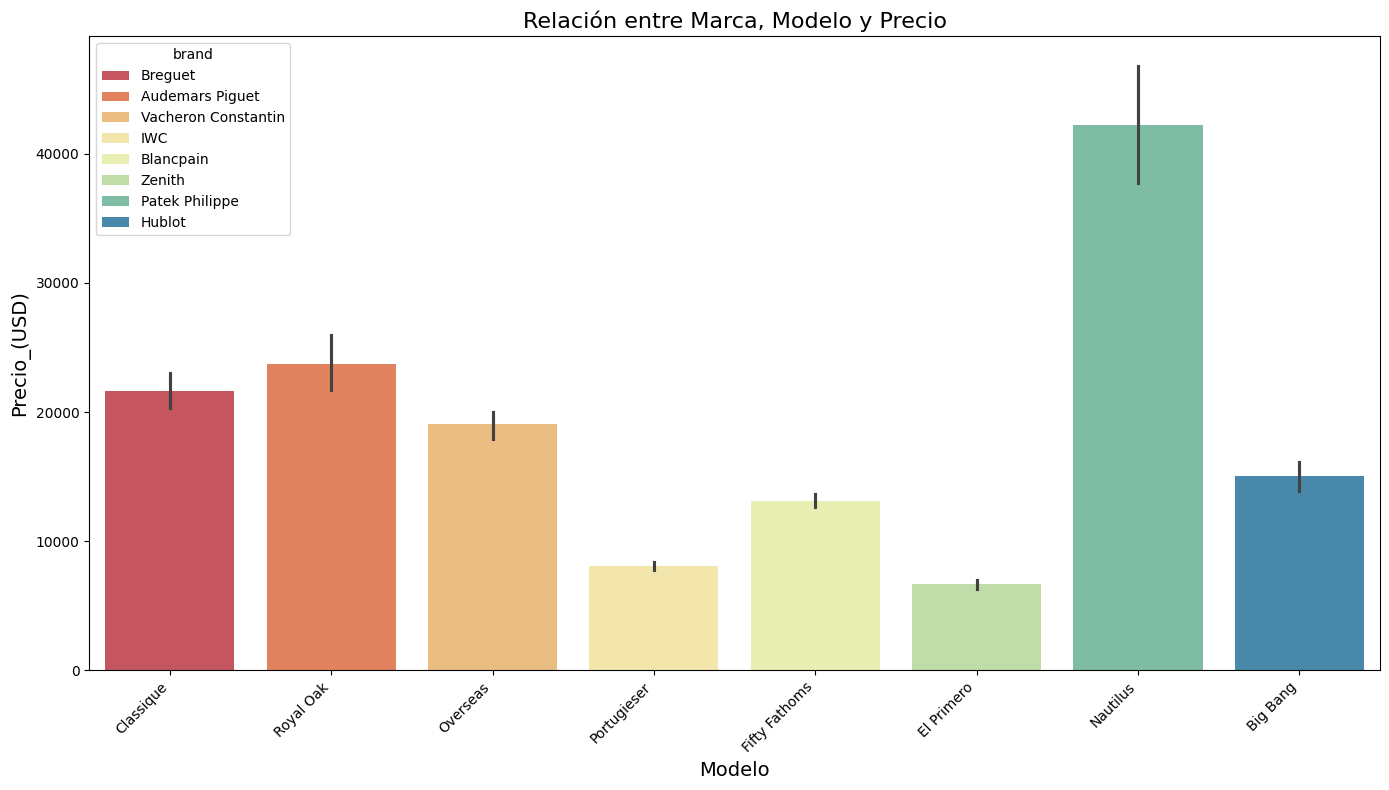

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Filtrar las 10 marcas más frecuentes
top_brands = df['brand'].value_counts().nlargest(10).index

# Filtrar las 10 modelos más frecuentes
top_models = df['model'].value_counts().nlargest(10).index

# Filtrar el DataFrame para quedarnos solo con las 10 marcas y 10 modelos más frecuentes
filtered_df = df[df['brand'].isin(top_brands) & df['model'].isin(top_models)]

# Crear el gráfico de barras
plt.figure(figsize=(14, 8))

# Usamos 'price' (USD) como eje y, 'brand' y 'model' como ejes categóricos
sns.barplot(x='model', y='price_(usd)', hue='brand', data=filtered_df, palette='Spectral')

# Título y etiquetas
plt.title('Relación entre Marca, Modelo y Precio', fontsize=16)
plt.xlabel('Modelo', fontsize=14)
plt.ylabel('Precio_(USD)', fontsize=14)

# Mejorar la legibilidad de los ejes y la leyenda
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Mostrar el gráfico
plt.show()


### Análisis de la Relación entre Material de la Caja (CaseMaterial) y Autonomía del Reloj (PowerReserve)

**Objetivo del análisis**:  
El objetivo es analizar cómo se distribuyen las diferentes autonomías de los relojes según el material de la caja. Esto nos permite observar cómo varían las autonomías dentro de cada material y cómo estas están relacionadas con el precio promedio.

**Gráfico de Barras Apiladas**:  
Hemos utilizado un gráfico de barras apiladas para visualizar de manera clara la distribución de los **materiales de la caja** y la **autonomía del reloj**. Este gráfico nos ayuda a analizar cómo se distribuyen las autonomías dentro de cada material de la caja, permitiéndonos ver las variaciones dentro de cada categoría.

- **Conclusión del gráfico**:  
  La mayoría de los materiales de la caja muestran una distribución limitada de autonomías, con pocos tipos de autonomía asociados a cada material. Sin embargo, **Stainless Steel** (acero inoxidable) se destaca por tener una gran variedad de autonomías. Le siguen **Titanium** (titanio) y **Rose Gold** (oro rosa), que también tienen varias autonomías. El resto de materiales tienden a tener un rango más limitado de autonomías.

<Figure size 1200x800 with 0 Axes>

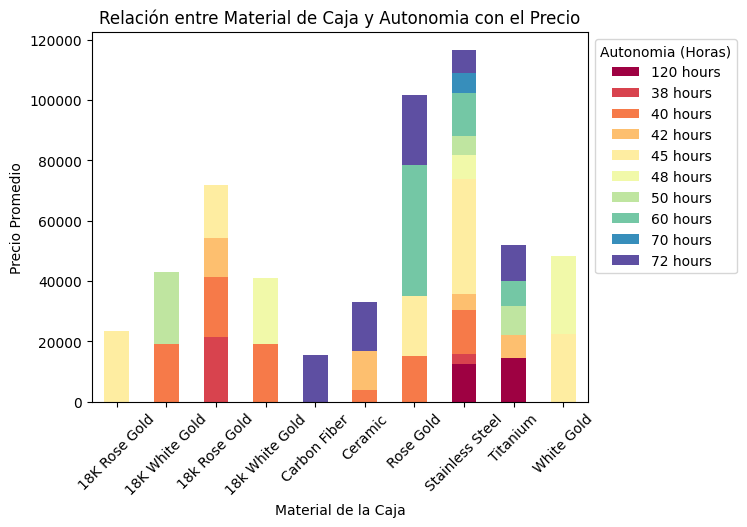

In [42]:
# Filtrar las 10 mmateriales y autonomia  más frecuentes
top_case_materials = df['case_material'].value_counts().nlargest(10).index
top_power_reserve = df['power_reserve'].value_counts().nlargest(10).index

# Filtrar el DataFrame para las 10 categorías más frecuentes
df_filtered = df[df['case_material'].isin(top_case_materials) & df['power_reserve'].isin(top_power_reserve)]

# Agrupar por Material de la Caja y Reserva de Marcha, calculando el precio medio
pivot_table = df_filtered.pivot_table(index='case_material', columns='power_reserve', values='price_(usd)', aggfunc='mean')

# Crear un gráfico de barras apiladas con la paleta 'coolwarm'
plt.figure(figsize=(12, 8))
pivot_table.plot(kind='bar', stacked=True, colormap="Spectral")
plt.title('Relación entre Material de Caja y Autonomia con el Precio')
plt.xlabel('Material de la Caja')
plt.ylabel('Precio Promedio')
plt.xticks(rotation=45)
plt.legend(title='Autonomia (Horas)', bbox_to_anchor=(1, 1))
plt.show()


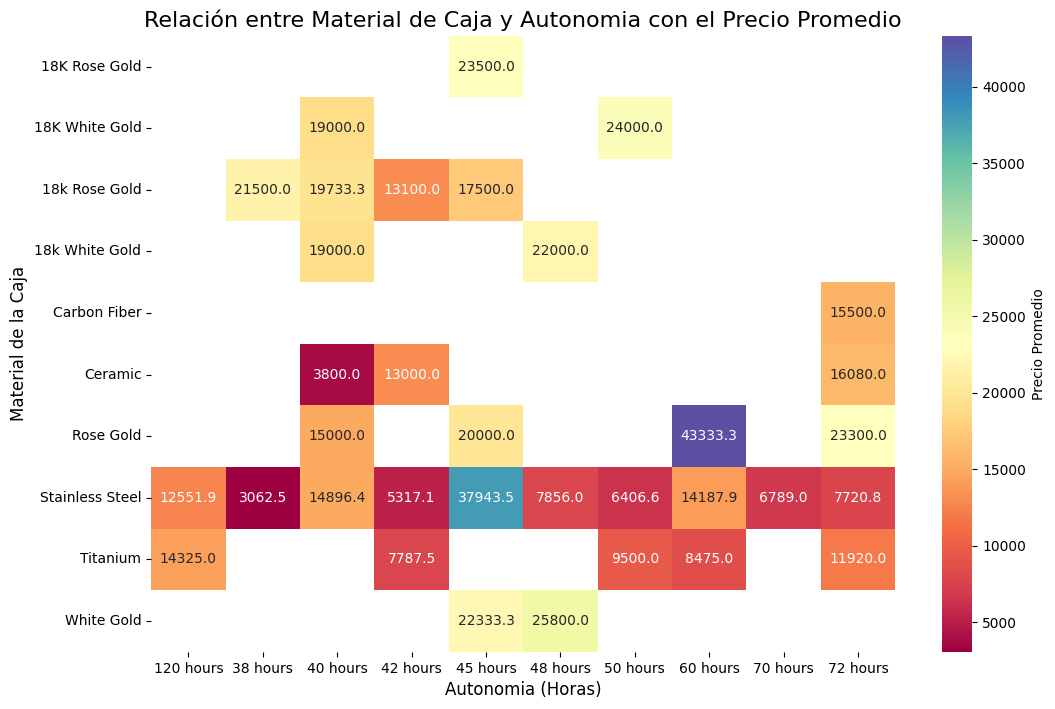

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filtramos las 10 variables más comunes, según lo que mencionamos anteriormente.
top_materials = df['case_material'].value_counts().head(10).index
top_reserves = df['power_reserve'].value_counts().head(10).index

# Filtramos el DataFrame por estos valores más comunes
df_filtered = df[df['case_material'].isin(top_materials) & df['power_reserve'].isin(top_reserves)]

# Crear la tabla de contingencia
heatmap_data = pd.crosstab(df_filtered['case_material'], df_filtered['power_reserve'], values=df_filtered['price_(usd)'], aggfunc='mean')

# Crear el heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, cmap="Spectral", cbar_kws={'label': 'Precio Promedio'}, fmt='.1f')

# Añadir título y etiquetas
plt.title('Relación entre Material de Caja y Autonomia con el Precio Promedio', fontsize=16)
plt.xlabel('Autonomia (Horas)', fontsize=12)
plt.ylabel('Material de la Caja', fontsize=12)

# Mostrar el gráfico
plt.show()


**Heatmap**:  
Además, hemos utilizado un **Heatmap** para visualizar la relación entre el **material de la caja** y la **autonomía del reloj**. Este tipo de gráfico es útil para identificar patrones y concentraciones de valores en los datos. Nos permite ver de manera clara las combinaciones más prevalentes de materiales y autonomías.

- **Conclusión del Heatmap**:  
  Al observar el Heatmap, podemos identificar que las combinaciones más prevalentes son **Stainless Steel** con **45 horas de autonomía** y **Rose Gold** con **60 horas de autonomía**. Estas combinaciones se destacan por tener una mayor intensidad de color, lo que indica que son las más comunes en el conjunto de datos.

**Resumen**:  
El análisis muestra que **Stainless Steel** tiene la mayor variedad de autonomías, mientras que otros materiales como **Titanium** y **Rose Gold** también ofrecen una buena variedad, aunque no tan amplia. El **Heatmap** refuerza estas conclusiones, destacando las combinaciones más frecuentes y mostrándonos cómo se distribuyen estas relaciones en el conjunto de datos.

### Análisis de la Distribución de Precio por Funcionalidades y Autonomía

Hemos utilizado un **scatterplot** para visualizar la relación entre el precio de los relojes, sus funcionalidades y la autonomía de la reserva de marcha. Aunque este gráfico no es el más ideal para visualizar relaciones complejas entre múltiples variables, nos permite obtener una visión general de las tendencias de los datos. A partir de este análisis, podemos extraer algunas conclusiones relevantes sobre las combinaciones de funcionalidades y autonomía.

- **DATE y CHRONOGRAPH**: Estas funcionalidades son bastante comunes y se distribuyen por todas las horas de autonomía.
- **DATE-GMT**: Esta combinación aparece con frecuencia y está asociada con **70 horas** de autonomía.
- **CHRONOGRAPH-TACHYMETER**: Tiene una autonomía de **60 horas**.
- **RESERVE-INDICATOR y DATE-POWER-RESERVE**: Estas combinaciones tienen autonomías de entre **60** y **42 horas**.

Esto nos lleva a la conclusión de que, en general, las autonomías más comunes se encuentran entre **38 y 42 horas**, como se había observado previamente en el análisis de autonomía.

##### Identificación de Redundancias y Agrupación de Funcionalidades

También hemos notado que algunas funcionalidades están duplicadas o expresadas de manera ligeramente diferente, como es el caso de "Chronograph Date" y "Date Chronograph", que deberían agruparse bajo una misma categoría. Para solucionar esto, se propone crear una nueva columna en el DataFrame que unifique estas funcionalidades bajo un único nombre para cada tipo, lo que reducirá los valores únicos de la columna **funcionalidades**.


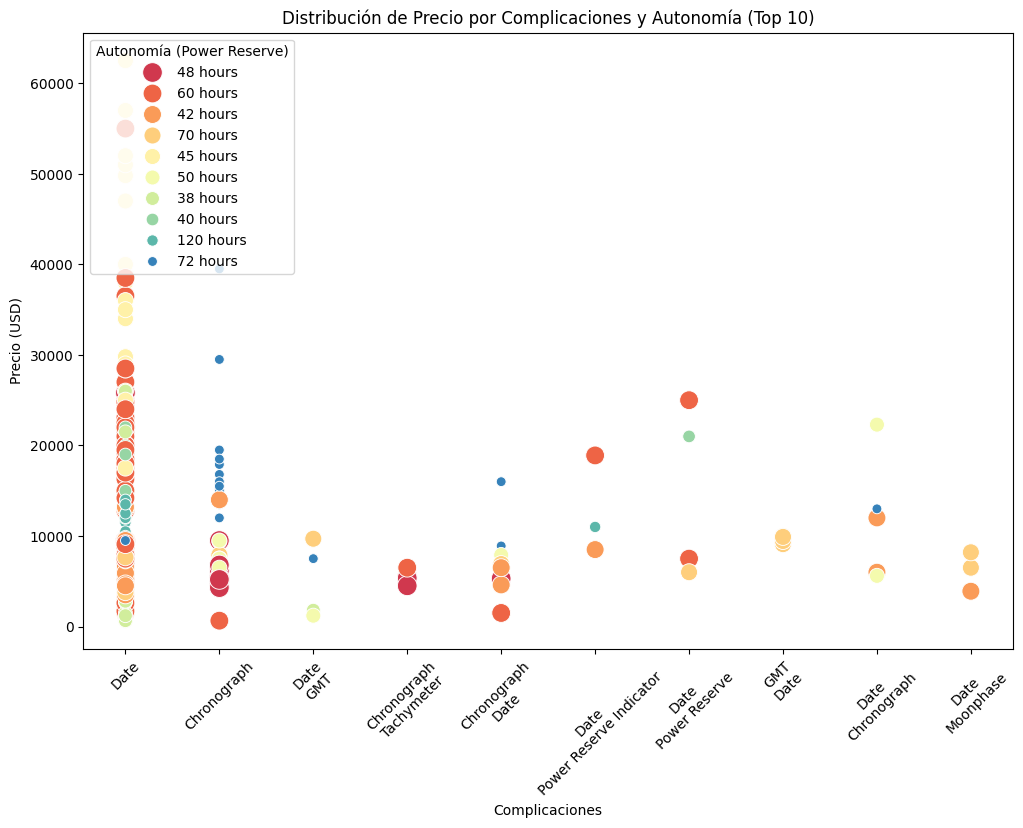

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filtramos los 10 valores más frecuentes para 'complications' y 'power_reserve'
top_10_complications = df['complications'].value_counts().nlargest(10).index
top_10_power_reserve = df['power_reserve'].value_counts().nlargest(10).index

# Filtramos el DataFrame para mantener solo esos valores
filtered_df = df[df['complications'].isin(top_10_complications) & df['power_reserve'].isin(top_10_power_reserve)]

# Creamos el gráfico de dispersión (scatterplot)
plt.figure(figsize=(12, 8))
sns.scatterplot(data=filtered_df, x='complications', y='price_(usd)', hue='power_reserve', size='power_reserve', 
                palette='Spectral', sizes=(50, 200), legend='full')

# Personalizamos el gráfico
plt.title('Distribución de Precio por Complicaciones y Autonomía (Top 10)')
plt.xlabel('Complicaciones')
plt.ylabel('Precio (USD)')

# Ajuste de las etiquetas del eje Y para que se dividan en varias líneas
labels = plt.gca().get_xticklabels()
new_labels = []

for label in labels:
    # Si hay una coma, separa los elementos y los coloca en líneas diferentes
    new_label = label.get_text().replace(", ", "\n")
    new_labels.append(new_label)

# Asignamos las nuevas etiquetas formateadas
plt.gca().set_xticklabels(new_labels, rotation=45)

# Leyenda
plt.legend(title='Autonomía (Power Reserve)', loc='upper left')

plt.show()


### **Conclusiones del Análisis Categórico y su Impacto en el Modelo Predictivo**

Durante el análisis de las **variables categóricas**, hemos observado que las más influyentes en el precio son **marca**, **modelo**, **autonomía**, **funcionalidades** y **material**, siendo **marca** y **modelo** las de mayor cardinalidad. Esto nos indica que estas variables tienen un impacto significativo en el precio, por lo que serán claves en nuestro modelo predictivo.

A través del **test de Kruskal-Wallis**, confirmamos que **marca** y **modelo** tienen una relación fuerte con el precio, mientras que **autonomía** y **funcionalidades** también influyen, aunque de manera menos directa. Es importante resaltar que ciertas combinaciones de **funcionalidades** (como **chronograph date** y **date chronograph**) se encuentran duplicadas, lo que podría afectar la calidad del modelo si no se corrige.

En el análisis multivariante, identificamos que **autonomía** y **funcionalidades** presentan una relación más compleja con el precio, pero siguen siendo relevantes. Para optimizar el modelo, es esencial **agrupar** las funcionalidades similares y las autonomías en rangos.

**Próximos pasos**: Transformar y agrupar correctamente estas variables nos permitirá simplificar el modelo y mejorar su capacidad predictiva. La codificación adecuada de **marca**, **modelo**, **autonomía** y **funcionalidades** será crucial para que el modelo aprenda las relaciones correctas entre estas variables y el precio.


### TRANSFORMACIONES

In [45]:
df.columns

Index(['brand', 'model', 'case_material', 'strap_material', 'movement_type',
       'water_resistance', 'case_diameter_(mm)', 'case_thickness_(mm)',
       'band_width_(mm)', 'dial_color', 'crystal_material', 'complications',
       'power_reserve', 'price_(usd)', 'water_resistance_numeric',
       'power_reserve_numeric'],
      dtype='object')

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 506 entries, 0 to 506
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   brand                     506 non-null    object 
 1   model                     506 non-null    object 
 2   case_material             506 non-null    object 
 3   strap_material            506 non-null    object 
 4   movement_type             506 non-null    object 
 5   water_resistance          506 non-null    object 
 6   case_diameter_(mm)        506 non-null    float64
 7   case_thickness_(mm)       506 non-null    float64
 8   band_width_(mm)           506 non-null    float64
 9   dial_color                506 non-null    object 
 10  crystal_material          506 non-null    object 
 11  complications             506 non-null    object 
 12  power_reserve             506 non-null    object 
 13  price_(usd)               506 non-null    int64  
 14  water_resistanc

In [47]:
df

,brand,model,case_material,strap_material,movement_type,water_resistance,case_diameter_(mm),case_thickness_(mm),band_width_(mm),dial_color,crystal_material,complications,power_reserve,price_(usd),water_resistance_numeric,power_reserve_numeric
0,Rolex,Submariner,Stainless Steel,Stainless Steel,Automatic,300 meters,40.0,13.00,20.0,Black,Sapphire,Date,48 hours,9500,300.0,48.0
1,Omega,Seamaster,Titanium,Rubber,Automatic,600 meters,44.0,14.47,21.0,Blue,Sapphire,Date,60 hours,5800,600.0,60.0
2,Tag Heuer,Carrera,Stainless Steel,Leather,Automatic,100 meters,41.0,13.00,20.0,White,Sapphire,Chronograph,42 hours,4200,100.0,42.0
3,Breitling,Navitimer,Stainless Steel,Stainless Steel,Automatic,30 meters,43.0,14.25,22.0,Black,Sapphire,Chronograph,70 hours,7900,30.0,70.0
4,Cartier,Tank Solo,Stainless Steel,Leather,Quartz,30 meters,31.0,6.05,20.0,Silver,Sapphire,Date,60 hours,2800,30.0,60.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
502,Breguet,Classique,18k Rose Gold,Leather,Automatic,30 meters,38.0,8.25,20.0,White,Sapphire,Date,38 hours,21500,30.0,38.0
503,Blancpain,Fifty Fathoms,Stainless Steel,Fabric,Automatic,300 meters,45.0,15.50,23.0,Black,Sapphire,Date,120 hours,13500,300.0,120.0
504,Longines,Master Collection,Stainless Steel,Leather,Automatic,30 meters,38.0,9.70,20.0,Blue,Sapphire,Date,64 hours,1800,30.0,64.0
505,Vacheron Constantin,Overseas,Stainless Steel,Stainless Steel,Automatic,150 meters,42.0,11.00,22.0,Blue,Sapphire,Date,40 hours,19000,150.0,40.0


In [48]:
df_primero=df.copy()

In [49]:

# Seleccionar solo las variables categóricas
categorical_vars = df.select_dtypes(include=['object', 'category'])

# Contar los valores únicos de cada variable categórica
unique_counts = categorical_vars.nunique().reset_index()
unique_counts.columns = ['Variable', 'Valores Únicos']

# Mostrar la tabla ordenada por número de valores únicos (de mayor a menor)
unique_counts = unique_counts.sort_values(by='Valores Únicos', ascending=False)

# Mostrar la tabla
print(unique_counts)


           Variable  Valores Únicos
1             model              95
0             brand              39
8     complications              29
9     power_reserve              24
2     case_material              17
3    strap_material              14
5  water_resistance              12
6        dial_color               7
4     movement_type               4
7  crystal_material               4


In [50]:
import pandas as pd

# Lista de variables que queremos analizar
variables_a_mapear = ['dial_color', 'movement_type', 'crystal_material']

# Crear un DataFrame con los valores únicos y su cantidad
unique_values = {var: df[var].unique() for var in variables_a_mapear}
num_unique = {var: len(df[var].unique()) for var in variables_a_mapear}

# Convertir en DataFrame para mejor visualización
summary_df = pd.DataFrame({'Valores Únicos': num_unique, 'Categorías': unique_values})

# Mostrar la tabla
summary_df


,Valores Únicos,Categorías
dial_color,7,"[Black, Blue, White, Silver, Ivory, Champagne,..."
movement_type,4,"[Automatic, Quartz, Manual, Eco-Drive]"
crystal_material,4,"[Sapphire, Mineral, Hesalite, Hardlex]"


In [51]:
df.columns

Index(['brand', 'model', 'case_material', 'strap_material', 'movement_type',
       'water_resistance', 'case_diameter_(mm)', 'case_thickness_(mm)',
       'band_width_(mm)', 'dial_color', 'crystal_material', 'complications',
       'power_reserve', 'price_(usd)', 'water_resistance_numeric',
       'power_reserve_numeric'],
      dtype='object')

In [52]:
numerical_features = ['price_(usd)', 'case_diameter_(mm)', 'case_thickness_(mm)', 'band_width_(mm)', 
                      'power_reserve_numeric', 'water_resistance_numeric']


In [53]:
df_origin=df.copy()


##### GENERACION DE NUEVA VARIABLE CLUSTERS

In [54]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
# Seleccionar las características numéricas
numerical_features = ['price_(usd)', 'case_diameter_(mm)', 'case_thickness_(mm)', 'band_width_(mm)','power_reserve_numeric', 'water_resistance_numeric']

# Escalar las características numéricas
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[numerical_features])

kmeans = KMeans(n_clusters=5, random_state=42)
df['cluster'] = kmeans.fit_predict(df[numerical_features])
# Ver cuántos relojes hay en cada cluster
print(df['cluster'].value_counts().sort_index())

cluster
0    171
1     23
2    101
3     12
4    199
Name: count, dtype: int64


In [55]:
cluster_summary = df.groupby('cluster')[['price_(usd)', 'case_diameter_(mm)', 'water_resistance_numeric', 'power_reserve_numeric']].mean()
cluster_summary


,price_(usd),case_diameter_(mm),water_resistance_numeric,power_reserve_numeric
cluster,,,,
0,9924.561404,41.730994,131.578947,69.204678
1,33047.826087,39.956522,95.217391,52.782609
2,20782.178218,40.376238,66.930693,55.871287
3,54233.333333,40.583333,114.166667,49.000000
4,4557.688442,40.894472,146.231156,53.824121


cluster
0    254
1     85
2     33
3    129
4      5
dtype: int64


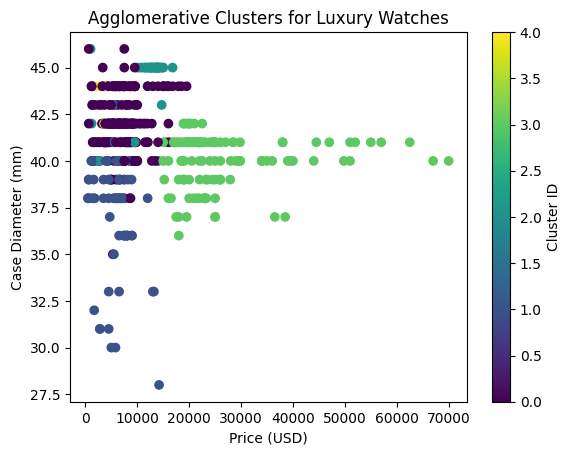

In [56]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt


# Aplicar Agglomerative Clustering
agg_clust = AgglomerativeClustering(n_clusters=5)  # Ajustar el threshold según sea necesario
df['cluster'] = agg_clust.fit_predict(scaled_features)

# Revisar el número de muestras por cluster
print(df.groupby('cluster').size())

# Visualizar los clusters en un gráfico (por ejemplo, Price vs Case Diameter)
plt.scatter(df['price_(usd)'], df['case_diameter_(mm)'], c=df['cluster'], cmap='viridis')
plt.xlabel('Price (USD)')
plt.ylabel('Case Diameter (mm)')
plt.title('Agglomerative Clusters for Luxury Watches')
plt.colorbar(label='Cluster ID')
plt.show()

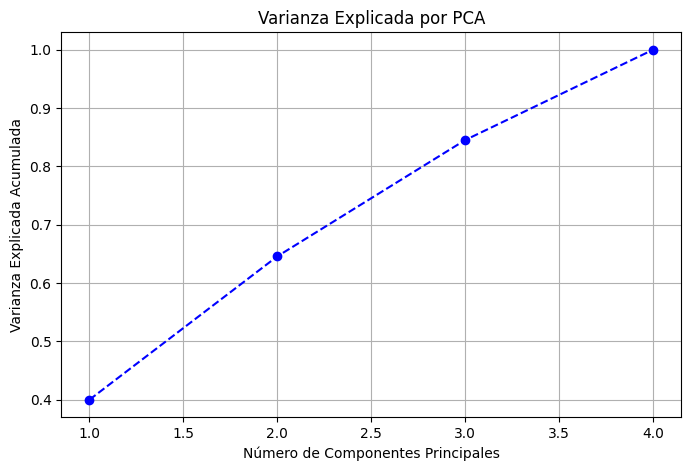

🔹 Número óptimo de componentes principales: 4


In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

#  1. Seleccionar solo las variables numéricas relevantes
numeric_features = ['price_(usd)', 'case_diameter_(mm)', 'water_resistance_numeric', 'power_reserve_numeric']
df_numeric = df[numeric_features]

#  2. Escalar los datos
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_numeric)

#  3. Aplicar PCA
pca = PCA(n_components=len(numeric_features))  # Número máximo de componentes = número de variables numéricas
df_pca = pca.fit_transform(df_scaled)

#  4. Visualizar la varianza explicada
explained_variance = np.cumsum(pca.explained_variance_ratio_)  # Varianza acumulada

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(numeric_features) + 1), explained_variance, marker='o', linestyle='--', color='b')
plt.xlabel('Número de Componentes Principales')
plt.ylabel('Varianza Explicada Acumulada')
plt.title('Varianza Explicada por PCA')
plt.grid()
plt.show()

#  5. Elegir cuántos componentes usar (95% de varianza)
n_components_optimo = np.argmax(explained_variance >= 0.95) + 1  # Primer índice donde la varianza acumulada ≥ 95%

print(f"🔹 Número óptimo de componentes principales: {n_components_optimo}")



In [58]:
# Obtener las componentes principales (loadings)
pca_components = pca.components_

# Crear un DataFrame con las componentes principales y las características originales
pca_df = pd.DataFrame(pca_components, columns=numeric_features)
pca_df


,price_(usd),case_diameter_(mm),water_resistance_numeric,power_reserve_numeric
0,-0.250622,0.614481,0.557374,0.498934
1,0.904418,0.150668,-0.104324,0.385285
2,-0.344075,-0.115664,-0.636425,0.680586
3,-0.028811,0.765725,-0.522890,-0.373393


## 🔍 Conclusión del Análisis PCA  

El Análisis de Componentes Principales (PCA) nos permitió reducir la dimensionalidad de los datos manteniendo el 95% de la varianza con solo **4 componentes principales**. Observamos que:  

- **El diámetro de la caja y la resistencia al agua** son los factores más relevantes en la primera componente.  
- **El precio y la reserva de energía** dominan la segunda componente.  
- Existe una **relación inversa entre la resistencia al agua y la reserva de energía**, capturada en la tercera componente.  
- La cuarta componente refleja diferencias entre **diámetro de la caja y resistencia al agua**.  

Este análisis sugiere que podemos utilizar estos 4 componentes en lugar de las variables originales para mejorar la eficiencia del modelo sin perder información clave. También nos permite identificar qué características son más relevantes para el análisis de precios de los relojes.  


### TRANFORMACIONES MAPEOS Y PIPELINE

In [59]:
# Mapeo de StrapMaterial
strap_mapping = {
    "Leather": "Leather",
    "Stainless Steel": "Stainless Steel",
    "Rubber": "Rubber"
}
df["strap_material"] = df["strap_material"].map(strap_mapping).fillna("Other")

# Mapeo de DialColor
dial_mapping = {
    "Black": "Black",
    "Blue": "Blue",
    "White": "White"
}
df["dial_color"] = df["dial_color"].map(dial_mapping).fillna("Other")

# Verificación de cambios
print("Distribución de Strap_Material después del mapeo:")
print(df["strap_material"].value_counts())

print("\nDistribución de DialColor después del mapeo:")
print(df["dial_color"].value_counts())

Distribución de Strap_Material después del mapeo:
strap_material
Leather            224
Stainless Steel    166
Rubber              73
Other               43
Name: count, dtype: int64

Distribución de DialColor después del mapeo:
dial_color
Black    216
Blue     136
Other    121
White     33
Name: count, dtype: int64


In [60]:
# Función para clasificar complications
def categorize_complications(value):
    value = str(value).lower()  # Convertir a string y minúsculas para evitar problemas de formato
    has_date = "date" in value
    has_chronograph = "chronograph" in value

    if has_date and has_chronograph:
        return "Mix"
    elif has_date:
        return "Date"
    elif has_chronograph:
        return "Chronograph"
    else:
        return "Other"

# Aplicar la función a la columna complications
df["complications_group"] = df["complications"].apply(categorize_complications)

# Ver distribución
print(df["complications_group"].value_counts())


complications_group
Date           391
Chronograph     86
Mix             22
Other            7
Name: count, dtype: int64


In [61]:

# Función para clasificar case_material
def categorize_case_material(value):
    value = str(value).lower()  # Convertimos a minúsculas para evitar diferencias de formato

    if "steel" in value:
        return "Steel"
    elif "titanium" in value:
        return "Titanium"
    elif "gold" in value:
        return "Gold"
    else:
        return "Other"  # Para cerámica, platino, carbono, etc.

# Aplicar la función a la columna case_material
df["case_material_group"] = df["case_material"].apply(categorize_case_material)

# Ver distribución
print(df["case_material_group"].value_counts())

case_material_group
Steel       405
Gold         51
Titanium     37
Other        13
Name: count, dtype: int64


In [62]:
df_clusters=df.copy()

In [63]:
# Agrupar Brand por Cluster más frecuente
brand_mapping_cluster = df.groupby("brand")["cluster"].apply(lambda x: x.mode()[0])  # Modificando por cluster
df["brand_group_cluster"] = df["brand"].map(brand_mapping_cluster)

# Agrupar Model por Cluster más frecuente
model_mapping_cluster = df.groupby("model")["cluster"].apply(lambda x: x.mode()[0])  # Modificando por cluster
df["model_group_cluster"] = df["model"].map(model_mapping_cluster)

# Verificar los cambios
print("Distribución de brand_group_cluster:")
print(df["brand_group_cluster"].value_counts())

print("\nDistribución de model_group_cluster:")
print(df["model_group_cluster"].value_counts())

Distribución de brand_group_cluster:
brand_group_cluster
0    289
3    131
1     54
2     32
Name: count, dtype: int64

Distribución de model_group_cluster:
model_group_cluster
0    261
3    130
1     75
2     32
4      8
Name: count, dtype: int64


In [64]:
df_models=df.copy()

In [65]:
df_models.info()

<class 'pandas.core.frame.DataFrame'>
Index: 506 entries, 0 to 506
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   brand                     506 non-null    object 
 1   model                     506 non-null    object 
 2   case_material             506 non-null    object 
 3   strap_material            506 non-null    object 
 4   movement_type             506 non-null    object 
 5   water_resistance          506 non-null    object 
 6   case_diameter_(mm)        506 non-null    float64
 7   case_thickness_(mm)       506 non-null    float64
 8   band_width_(mm)           506 non-null    float64
 9   dial_color                506 non-null    object 
 10  crystal_material          506 non-null    object 
 11  complications             506 non-null    object 
 12  power_reserve             506 non-null    object 
 13  price_(usd)               506 non-null    int64  
 14  water_resistanc

In [66]:
# Eliminamos las columnas 'water_resistance' y 'power_reserve' del DataFrame
df_models.drop(columns=['water_resistance', 'power_reserve','brand', 'model', 'case_material','complications'], inplace=True)

In [78]:
df_models.info()

<class 'pandas.core.frame.DataFrame'>
Index: 506 entries, 0 to 506
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   strap_material            506 non-null    object 
 1   movement_type             506 non-null    object 
 2   case_diameter_(mm)        506 non-null    float64
 3   case_thickness_(mm)       506 non-null    float64
 4   band_width_(mm)           506 non-null    float64
 5   dial_color                506 non-null    object 
 6   crystal_material          506 non-null    object 
 7   price_(usd)               506 non-null    int64  
 8   water_resistance_numeric  506 non-null    float64
 9   power_reserve_numeric     506 non-null    float64
 10  cluster                   506 non-null    int64  
 11  complications_group       506 non-null    object 
 12  case_material_group       506 non-null    object 
 13  brand_group_cluster       506 non-null    int64  
 14  model_group_clu

In [67]:
# Separar el target (target es 'price_(usd)')
X = df_models.drop(columns=['price_(usd)'])  # Variables predictoras
y = df_models['price_(usd)']  # Variable objetivo (escala logarítmica)

In [68]:
# Dividir los datos en entrenamiento y prueba (80% train, 20% test)
'''X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)'''
train_set, test_set = train_test_split(df_models, test_size= 0.2, random_state= 42) 

In [69]:
#  Guardar los sets de entrenamiento y prueba en archivos CSV
train_set.to_csv("generalreg_train.csv", index=False)
test_set.to_csv("generalreg_test.csv", index=False)

X_train = train_set.copy()
X_train = train_set.drop(target, axis = 1)

y_train = train_set['price_(usd)']

X_test = test_set.copy()
X_test = test_set.drop(target, axis = 1)

y_test = test_set['price_(usd)']

In [70]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

# Variables categóricas a transformar
categorical_columns = ['strap_material', 'movement_type', 'dial_color',
       'crystal_material', 'complications_group', 'case_material_group']  # Añadir las categóricas que hayas seleccionado

# Pipeline para variables categóricas
categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Rellenar los valores faltantes con el más frecuente
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))  # Codificación OneHot
])


In [71]:
from sklearn.preprocessing import FunctionTransformer 
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
import numpy as np

# Variables numéricas a transformar
numerical_columns = ['case_diameter_(mm)', 'band_width_(mm)', 'case_thickness_(mm)','water_resistance_numeric', 'power_reserve_numeric','brand_group_cluster',
       'model_group_cluster','cluster']  # Ajusta según tus variables


def log_transform(x):
    return np.log1p(x)  # Usamos log1p para evitar log(0)

# Las variables que aplicarían el logaritmo
log_transform_columns = ['water_resistance_numeric', 'power_reserve_numeric']  # Ajusta según las variables sesgadas

# Dividir las variables numéricas en log-transformadas y no transformadas
numerical_columns_log = [col for col in numerical_columns if col in log_transform_columns]
numerical_columns_no_log = [col for col in numerical_columns if col not in log_transform_columns]

# Pipeline para las variables numéricas (log-transformed)
numerical_pipeline_log = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Imputar valores faltantes con la media
    ('log_transform', FunctionTransformer(log_transform, validate=False)),  # Aplicar logaritmo solo a las variables sesgadas
    ('scaler', MinMaxScaler())  # Escalar las variables numéricas
])

# Pipeline para las variables numéricas sin log
numerical_pipeline_no_log = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Imputar valores faltantes con la media
    ('scaler', MinMaxScaler())  # Escalar las variables numéricas

])

In [72]:
# Crear el ColumnTransformer para aplicar las transformaciones a las columnas categóricas y numéricas
preprocessor = ColumnTransformer(
    transformers=[
        ('num_log', numerical_pipeline_log, numerical_columns_log),  # Aplicar log a las variables sesgadas
        ('num_no_log', numerical_pipeline_no_log, numerical_columns_no_log),
        ('cat', categorical_pipeline, categorical_columns)
    ], remainder = 'drop')

# Crear el pipeline final
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

# Ajustar el pipeline a los datos de entrenamiento
pipeline.fit(X_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_log',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('log_transform',
                                                                   FunctionTransformer(func=<function log_transform at 0x00000203C1E63380>)),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['water_resistance_numeric',
                                                   'power_reserve_numeric']),
                                                 ('num_no_log',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('s...
                                                   'band_width_(mm)',
                                                   'case_thickness_(mm)',
                                                   'brand_group_cluster',
                                                   'model_group_cluster',
                                                   'cluster']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['strap_material',
                                                   'movement_type',
                                                   'dial_color',
                                                   'crystal_material',
                                                   'complications_group',
                                                   'case_material_group'])]))])

In [73]:
X_train_transformed = pipeline.transform(X_train)  # Aplicamos el preprocesamiento a los datos de entrenamiento
X_test_transformed = pipeline.transform(X_test)    # Aplicamos el mismo preprocesamiento a los datos de test

In [74]:
import joblib

# Guardar el pipeline en un archivo
joblib.dump(pipeline, "pipeline_preprocesamiento.joblib")

# Para cargarlo más adelante:
# pipeline_cargado = joblib.load("pipeline_preprocesamiento.joblib")

['pipeline_preprocesamiento.joblib']

### **Evaluación de Modelos: Validación Cruzada y Selección de la Mejor Opción**  

Tras haber construido nuestro pipeline y transformado los datos, el siguiente paso es evaluar distintos modelos de regresión para predecir el precio de los relojes de lujo. Para ello, utilizamos **validación cruzada**, que nos permite medir el rendimiento de cada modelo sin depender demasiado de un solo conjunto de datos, reduciendo el riesgo de overfitting o underfitting.  

Hemos seleccionado los siguientes modelos por sus características y capacidades específicas:  

- **Regresión Lineal**: Punto de partida para evaluar relaciones lineales entre las variables.  
- **Ridge Regression**: Variante de la regresión lineal que reduce la multicolinealidad mediante regularización L2.  
- **Lasso Regression**: Similar a Ridge, pero con regularización L1, lo que ayuda a seleccionar características eliminando las menos relevantes.  
- **ElasticNet**: Combinación de Ridge y Lasso, equilibrando la regularización L1 y L2.  
- **Random Forest**: Modelo basado en árboles que maneja relaciones no lineales y es robusto ante valores atípicos.  
- **Gradient Boosting**: Modelo ensamblado basado en boosting que optimiza predicciones mediante aprendizaje secuencial.  
- **XGBoost**: Variante optimizada de Gradient Boosting con mejoras en velocidad y manejo de sobreajuste.  
- **LightGBM**: Similar a XGBoost, pero más eficiente con grandes volúmenes de datos.  
- **CatBoost**: Especializado en datos categóricos, lo que puede ser útil en nuestro conjunto de datos.  
- **SVR (Support Vector Regression)**: Busca maximizar el margen de predicción, útil cuando hay relaciones complejas en los datos.  
- **MLP Regressor (Redes Neuronales)**: Puede capturar patrones complejos mediante capas ocultas, aunque requiere más datos y ajustes.  

Una vez entrenados estos modelos con validación cruzada, analizamos sus métricas de error (RMSE) para identificar cuál ofrece la mejor capacidad predictiva y tomar decisiones sobre posibles ajustes.  

In [75]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
from sklearn.model_selection import cross_val_score
import numpy as np

# Diccionario de modelos
models = {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'ElasticNet': ElasticNet(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'XGBoost': xgb.XGBRegressor(objective='reg:squarederror', random_state=42, verbosity=0),
    'LightGBM': lgb.LGBMRegressor(random_state=42, verbose=-1),
    'CatBoost': cb.CatBoostRegressor(verbose=0, random_state=42),
    'SVR': SVR(),
    'MLP Regressor': MLPRegressor(random_state=42, max_iter=1000)
}

# Evaluación con validación cruzada
cv_results = {}

for name, model in models.items():
    try:
        score = np.mean(-cross_val_score(model, X_train_transformed, y_train, cv=5, scoring='neg_root_mean_squared_error'))
        cv_results[name] = score
        print(f"{name}: RMSE {score:.2f}")
    except Exception as e:
        cv_results[name] = None
        print(f"⚠️ Error en {name}: {e}")

# Ordenar los resultados de menor a mayor RMSE
cv_results_sorted = sorted(cv_results.items(), key=lambda x: x[1] if x[1] is not None else float('inf'))

# Mostrar resultados
print("\n🔹 Resultados de validación cruzada (ordenados por RMSE):")
for name, score in cv_results_sorted:
    print(f"{name}: RMSE {score:.2f}" if score is not None else f"{name}: ❌ Error")

Linear Regression: RMSE 6453.80
Ridge: RMSE 6372.35
Lasso: RMSE 6395.09
ElasticNet: RMSE 7786.93
Random Forest: RMSE 4263.04
Gradient Boosting: RMSE 4283.02
⚠️ Error en XGBoost: 'super' object has no attribute '__sklearn_tags__'
LightGBM: RMSE 4197.33
CatBoost: RMSE 4326.03
SVR: RMSE 11070.17
MLP Regressor: RMSE 13052.19

🔹 Resultados de validación cruzada (ordenados por RMSE):
LightGBM: RMSE 4197.33
Random Forest: RMSE 4263.04
Gradient Boosting: RMSE 4283.02
CatBoost: RMSE 4326.03
Ridge: RMSE 6372.35
Lasso: RMSE 6395.09
Linear Regression: RMSE 6453.80
ElasticNet: RMSE 7786.93
SVR: RMSE 11070.17
MLP Regressor: RMSE 13052.19
XGBoost: ❌ Error


In [76]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline

# Crear el pipeline final con el modelo
pipeline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Transformaciones en X
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))  # Modelo
])

# Entrenar el modelo con los datos transformados y la variable target escalada
pipeline_rf.fit(X_train, y_train)  # Convertir a 1D con ravel()

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_log',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('log_transform',
                                                                   FunctionTransformer(func=<function log_transform at 0x00000203C1E63380>)),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['water_resistance_numeric',
                                                   'power_reserve_numeric']),
                                                 ('num_no_log',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('s...
                                                   'brand_group_cluster',
                                                   'model_group_cluster',
                                                   'cluster']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['strap_material',
                                                   'movement_type',
                                                   'dial_color',
                                                   'crystal_material',
                                                   'complications_group',
                                                   'case_material_group'])])),
                ('regressor', RandomForestRegressor(random_state=42))])

In [77]:
bfgsgtr

NameError: name 'bfgsgtr' is not defined

In [ ]:
df_clusters.drop(columns=['water_resistance', 'power_reserve','case_material','complications'], inplace=True)

In [ ]:
df_clusters

In [ ]:
df_clusters.info()

#### Preprocesamiento de Datos - Pipeline  

##### Descripción  
Se ha diseñado un **pipeline de preprocesamiento** para transformar variables categóricas y numéricas:  

1. **Categóricas:**  
   - Se imputan valores faltantes con la estrategia **"most_frequent"**.  
   - Se aplica **One-Hot Encoding** ignorando valores desconocidos.  

2. **Numéricas:**  
   - Se dividen en dos grupos:  
     - Variables con **distribución sesgada**: Se aplica una **transformación logarítmica**.  
     - Variables sin sesgo: Se mantienen sin transformación.  
   - A todas se les aplica **Min-Max Scaling** para normalización.  

3. **Integración:**  
   - Se combinan las transformaciones en un `ColumnTransformer` dentro del **pipeline final**.  

✅ **Automatización** del preprocesamiento, evitando fugas de datos.  
✅ **Escalado adecuado** que mejora el rendimiento de modelos sensibles a magnitudes.  
✅ **Codificación One-Hot** para representar correctamente variables categóricas
 
❌ **One-Hot Encoding** puede generar demasiadas columnas si hay muchas categorías.  
❌ **Transformación logarítmica** no es útil si los datos contienen valores negativos o ceros.  
❌ **Min-Max Scaling** es sensible a outliers extremos.  


In [ ]:
# Filtrar los datos para obtener solo las filas del clúster 0
df_cluster_0 = df_clusters[df_clusters['cluster'] == 0]

# Separar las variables predictoras (X) y la variable objetivo (y)
X_cluster_0 = df_cluster_0.drop(columns=["price_(usd)", "cluster"])  # Variables predictoras
y_cluster_0 = df_cluster_0["price_(usd)"]  # Variable objetivo

# Dividir los datos en conjunto de entrenamiento (80%) y conjunto de prueba (20%)
X_train_0, X_test_0, y_train_0, y_test_0 = train_test_split(X_cluster_0, y_cluster_0, test_size=0.2, random_state=42)

# Aplicar el pipeline de preprocesamiento a los datos de entrenamiento y prueba
# Transformar X_train y X_test con el pipeline previamente creado




In [ ]:
df_cluster_0.head()

In [ ]:
df_clusters[df_clusters["cluster"] == 0]

In [ ]:
X_train_0.columns

In [ ]:
X_train_0.info()

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

# Variables categóricas a transformar
categorical_columns = ['brand' ,'model', 'strap_material','dial_color','crystal_material','movement_type','complications_group', 'case_material_group']  # Añadir las categóricas que hayas seleccionado

# Pipeline para variables categóricas
categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Rellenar los valores faltantes con el más frecuente
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))  # Codificación OneHot
])


In [ ]:
from sklearn.preprocessing import FunctionTransformer 
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import numpy as np

# Variables numéricas a transformar
numerical_columns = ['case_diameter_(mm)', 'band_width_(mm)', 'case_thickness_(mm)','water_resistance_numeric', 'power_reserve_numeric']  # Ajusta según tus variables


def log_transform(x):
    return np.log1p(x)  # Usamos log1p para evitar log(0)

# Las variables que aplicarían el logaritmo
log_transform_columns = ['water_resistance_numeric', 'power_reserve_numeric']  # Ajusta según las variables sesgadas

# Dividir las variables numéricas en log-transformadas y no transformadas
numerical_columns_log = [col for col in numerical_columns if col in log_transform_columns]
numerical_columns_no_log = [col for col in numerical_columns if col not in log_transform_columns]

# Pipeline para las variables numéricas (log-transformed)
numerical_pipeline_log = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Imputar valores faltantes con la media
    ('log_transform', FunctionTransformer(log_transform, validate=False)),  # Aplicar logaritmo solo a las variables sesgadas
    ('scaler', StandardScaler())  # Escalar las variables numéricas
])

# Pipeline para las variables numéricas sin log
numerical_pipeline_no_log = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Imputar valores faltantes con la media
    ('scaler', StandardScaler())  # Escalar las variables numéricas

])


In [ ]:


# Crear el ColumnTransformer para aplicar las transformaciones a las columnas categóricas y numéricas
preprocessor = ColumnTransformer(
    transformers=[
        ('num_log', numerical_pipeline_log, numerical_columns_log),  # Aplicar log a las variables sesgadas
        ('num_no_log', numerical_pipeline_no_log, numerical_columns_no_log),
        ('cat', categorical_pipeline, categorical_columns)
    ], remainder = 'drop')

# Crear el pipeline final
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

# Ajustar el pipeline a los datos de entrenamiento
pipeline.fit(X_train_0)

In [ ]:
# Transformación de X_train y X_test usando el pipeline predefinido
X_train_0_transformed = pipeline.fit_transform(X_train_0)  # Usamos fit_transform en X_train para ajustar y transformar
X_test_0_transformed = pipeline.transform(X_test_0)  # Usamos transform en X_test para solo transformar

In [ ]:
import joblib

# Guardar el pipeline en un archivo
joblib.dump(pipeline, "pipeline_preprocesamiento.joblib")

# Para cargarlo más adelante:
# pipeline_cargado = joblib.load("pipeline_preprocesamiento.joblib")

In [ ]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
from sklearn.model_selection import cross_val_score
import numpy as np

# Diccionario de modelos
models = {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'ElasticNet': ElasticNet(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'XGBoost': xgb.XGBRegressor(objective='reg:squarederror', random_state=42, verbosity=0),
    'LightGBM': lgb.LGBMRegressor(random_state=42, verbose=-1),
    'CatBoost': cb.CatBoostRegressor(verbose=0, random_state=42),
    'SVR': SVR(),
    'MLP Regressor': MLPRegressor(random_state=42, max_iter=1000)
}

# Evaluación con validación cruzada
cv_results = {}

for name, model in models.items():
    try:
        score = np.mean(-cross_val_score(model, X_train_0_transformed, y_train_0, cv=5, scoring='neg_root_mean_squared_error'))
        cv_results[name] = score
        print(f"{name}: RMSE {score:.2f}")
    except Exception as e:
        cv_results[name] = None
        print(f"⚠️ Error en {name}: {e}")

# Ordenar los resultados de menor a mayor RMSE
cv_results_sorted = sorted(cv_results.items(), key=lambda x: x[1] if x[1] is not None else float('inf'))

# Mostrar resultados
print("\n🔹 Resultados de validación cruzada (ordenados por RMSE):")
for name, score in cv_results_sorted:
    print(f"{name}: RMSE {score:.2f}" if score is not None else f"{name}: ❌ Error")

### **Evaluación de Modelos: Validación Cruzada y Selección de la Mejor Opción**  

Tras haber construido nuestro pipeline y transformado los datos, el siguiente paso es evaluar distintos modelos de regresión para predecir el precio de los relojes de lujo. Para ello, utilizamos **validación cruzada**, que nos permite medir el rendimiento de cada modelo sin depender demasiado de un solo conjunto de datos, reduciendo el riesgo de overfitting o underfitting.  

Hemos seleccionado los siguientes modelos por sus características y capacidades específicas:  

- **Regresión Lineal**: Punto de partida para evaluar relaciones lineales entre las variables.  
- **Ridge Regression**: Variante de la regresión lineal que reduce la multicolinealidad mediante regularización L2.  
- **Lasso Regression**: Similar a Ridge, pero con regularización L1, lo que ayuda a seleccionar características eliminando las menos relevantes.  
- **ElasticNet**: Combinación de Ridge y Lasso, equilibrando la regularización L1 y L2.  
- **Random Forest**: Modelo basado en árboles que maneja relaciones no lineales y es robusto ante valores atípicos.  
- **Gradient Boosting**: Modelo ensamblado basado en boosting que optimiza predicciones mediante aprendizaje secuencial.  
- **XGBoost**: Variante optimizada de Gradient Boosting con mejoras en velocidad y manejo de sobreajuste.  
- **LightGBM**: Similar a XGBoost, pero más eficiente con grandes volúmenes de datos.  
- **CatBoost**: Especializado en datos categóricos, lo que puede ser útil en nuestro conjunto de datos.  
- **SVR (Support Vector Regression)**: Busca maximizar el margen de predicción, útil cuando hay relaciones complejas en los datos.  
- **MLP Regressor (Redes Neuronales)**: Puede capturar patrones complejos mediante capas ocultas, aunque requiere más datos y ajustes.  

Una vez entrenados estos modelos con validación cruzada, analizamos sus métricas de error (RMSE) para identificar cuál ofrece la mejor capacidad predictiva y tomar decisiones sobre posibles ajustes.  


In [ ]:
# Importar Lasso
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
import numpy as np

# Asumiendo que ya has realizado el preprocesamiento y el pipeline

# Definir el modelo Lasso
lasso = Lasso(alpha=0.1)  # Puedes ajustar el parámetro alpha según el rendimiento

# Ajustar el modelo con el conjunto de entrenamiento (X_train_0 y y_train_0)
lasso.fit(X_train_0_transformed, y_train_0)

# Realizar predicciones sobre el conjunto de prueba
y_pred_lasso = lasso.predict(X_test_0_transformed)

# Evaluación del modelo
# Calcular el error cuadrático medio (RMSE)
rmse_lasso = np.sqrt(mean_squared_error(y_test_0, y_pred_lasso))
print(f"RMSE del modelo Lasso: {rmse_lasso}")

# Si también quieres calcular el R²
r2_lasso = lasso.score(X_test_0_transformed, y_test_0)
print(f"R² del modelo Lasso: {r2_lasso}")


In [ ]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

# Definir los rangos de alpha para buscar el mejor valor
param_grid = {'alpha': [0.01, 0.1, 1, 10, 100]}

# Crear el modelo Lasso
lasso = Lasso()

# Realizar GridSearchCV con validación cruzada
grid_search = GridSearchCV(estimator=lasso, param_grid=param_grid, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)

# Ajustar el modelo con los datos de entrenamiento
grid_search.fit(X_train_0_transformed, y_train_0)

# Mostrar el mejor valor de alpha encontrado
print(f"Mejor valor de alpha: {grid_search.best_params_['alpha']}")

# Obtener el mejor modelo ajustado
best_lasso = grid_search.best_estimator_

# Evaluar el modelo en los datos de prueba
y_pred_0 = best_lasso.predict(X_test_0_transformed)

# Calcular RMSE
from sklearn.metrics import mean_squared_error
import numpy as np

rmse = np.sqrt(mean_squared_error(y_test_0, y_pred_0))
print(f"RMSE del modelo Lasso con mejor alpha: {rmse}")


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

# Crear el modelo de regresión lineal
linear_reg = LinearRegression()

# Entrenar el modelo con los datos de entrenamiento
linear_reg.fit(X_train_0_transformed, y_train_0)

# Hacer las predicciones en los datos de prueba
y_pred_lr = linear_reg.predict(X_test_0_transformed)

# Calcular el RMSE (Raíz del Error Cuadrático Medio)
rmse_lr = np.sqrt(mean_squared_error(y_test_0, y_pred_lr))
print(f"RMSE del modelo de Regresión Lineal: {rmse_lr}")

# Calcular R^2 (coeficiente de determinación)
r2_lr = linear_reg.score(X_test_0_transformed, y_test_0)
print(f"R² del modelo de Regresión Lineal: {r2_lr}")


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression
import numpy as np

# Definir los parámetros para RandomizedSearchCV
param_dist = {
    'fit_intercept': [True, False],  # Ajustar si el modelo debe aprender el intercepto o no
}

# Crear el modelo de regresión lineal
linear_reg = LinearRegression()

# Crear RandomizedSearchCV con validación cruzada de 5 veces
random_search = RandomizedSearchCV(estimator=linear_reg, param_distributions=param_dist, 
                                   n_iter=10, cv=5, scoring='neg_root_mean_squared_error', 
                                   random_state=42, n_jobs=-1)

# Ajustar el modelo con los datos de entrenamiento
random_search.fit(X_train_0_transformed, y_train_0)

# Mostrar el mejor parámetro encontrado
print(f"Mejor parámetro de ajuste: {random_search.best_params_}")

# Obtener el mejor modelo ajustado
best_linear_reg = random_search.best_estimator_

# Hacer las predicciones en los datos de prueba
y_pred_lr_best = best_linear_reg.predict(X_test_0_transformed)

# Calcular RMSE con el mejor modelo
rmse_lr_best = np.sqrt(mean_squared_error(y_test_0, y_pred_lr_best))
print(f"RMSE del modelo de Regresión Lineal con RandomizedSearch: {rmse_lr_best}")

# Calcular R² con el mejor modelo
r2_lr_best = best_linear_reg.score(X_test_0_transformed, y_test_0)
print(f"R² del modelo de Regresión Lineal con RandomizedSearch: {r2_lr_best}")


In [ ]:
df_cluster_1 = df_clusters[df_clusters['cluster'] == 1]

# Separar las variables predictoras (X) y la variable objetivo (y)
X_cluster_1 = df_cluster_1.drop(columns=["price_(usd)", "cluster"])  # Variables predictoras
y_cluster_1 = df_cluster_1["price_(usd)"]  # Variable objetivo

# Dividir los datos en conjunto de entrenamiento (80%) y conjunto de prueba (20%)
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_cluster_1, y_cluster_1, test_size=0.2, random_state=42)

In [ ]:
# Variables categóricas a transformar
categorical_columns = ['brand' ,'model', 'strap_material','dial_color','crystal_material','movement_type','complications_group', 'case_material_group']  # Añadir las categóricas que hayas seleccionado

# Pipeline para variables categóricas
categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Rellenar los valores faltantes con el más frecuente
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))  # Codificación OneHot
])
# Variables numéricas a transformar
numerical_columns = ['case_diameter_(mm)', 'band_width_(mm)', 'case_thickness_(mm)','water_resistance_numeric', 'power_reserve_numeric']  # Ajusta según tus variables


def log_transform(x):
    return np.log1p(x)  # Usamos log1p para evitar log(0)

# Las variables que aplicarían el logaritmo
log_transform_columns = ['water_resistance_numeric', 'power_reserve_numeric']  # Ajusta según las variables sesgadas

# Dividir las variables numéricas en log-transformadas y no transformadas
numerical_columns_log = [col for col in numerical_columns if col in log_transform_columns]
numerical_columns_no_log = [col for col in numerical_columns if col not in log_transform_columns]

# Pipeline para las variables numéricas (log-transformed)
numerical_pipeline_log = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Imputar valores faltantes con la media
    ('log_transform', FunctionTransformer(log_transform, validate=False)),  # Aplicar logaritmo solo a las variables sesgadas
    ('scaler', StandardScaler())  # Escalar las variables numéricas
])

# Pipeline para las variables numéricas sin log
numerical_pipeline_no_log = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Imputar valores faltantes con la media
    ('scaler', StandardScaler())  # Escalar las variables numéricas

])
# Crear el ColumnTransformer para aplicar las transformaciones a las columnas categóricas y numéricas
preprocessor = ColumnTransformer(
    transformers=[
        ('num_log', numerical_pipeline_log, numerical_columns_log),  # Aplicar log a las variables sesgadas
        ('num_no_log', numerical_pipeline_no_log, numerical_columns_no_log),
        ('cat', categorical_pipeline, categorical_columns)
    ], remainder = 'drop')

# Crear el pipeline final
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

# Ajustar el pipeline a los datos de entrenamiento
pipeline.fit(X_train_1)


In [ ]:
# Transformación de X_train y X_test usando el pipeline predefinido
X_train_1_transformed = pipeline.fit_transform(X_train_1)  # Usamos fit_transform en X_train para ajustar y transformar
X_test_1_transformed = pipeline.transform(X_test_1)  # Usamos transform en X_test para solo transformar

In [ ]:
# Diccionario de modelos
models = {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'ElasticNet': ElasticNet(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'XGBoost': xgb.XGBRegressor(objective='reg:squarederror', random_state=42, verbosity=0),
    'LightGBM': lgb.LGBMRegressor(random_state=42, verbose=-1),
    'CatBoost': cb.CatBoostRegressor(verbose=0, random_state=42),
    'SVR': SVR(),
    'MLP Regressor': MLPRegressor(random_state=42, max_iter=1000)
}

# Evaluación con validación cruzada
cv_results = {}

for name, model in models.items():
    try:
        score = np.mean(-cross_val_score(model, X_train_1_transformed, y_train_1, cv=5, scoring='neg_root_mean_squared_error'))
        cv_results[name] = score
        print(f"{name}: RMSE {score:.2f}")
    except Exception as e:
        cv_results[name] = None
        print(f"⚠️ Error en {name}: {e}")

# Ordenar los resultados de menor a mayor RMSE
cv_results_sorted = sorted(cv_results.items(), key=lambda x: x[1] if x[1] is not None else float('inf'))

# Mostrar resultados
print("\n🔹 Resultados de validación cruzada (ordenados por RMSE):")
for name, score in cv_results_sorted:
    print(f"{name}: RMSE {score:.2f}" if score is not None else f"{name}: ❌ Error")

In [ ]:
df_clusters[df_clusters["cluster"] == 1]

In [ ]:
df_cluster_2 = df_clusters[df_clusters['cluster'] == 2]

# Separar las variables predictoras (X) y la variable objetivo (y)
X_cluster_2 = df_cluster_2.drop(columns=["price_(usd)", "cluster"])  # Variables predictoras
y_cluster_2 = df_cluster_2["price_(usd)"]  # Variable objetivo

# Dividir los datos en conjunto de entrenamiento (80%) y conjunto de prueba (20%)
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_cluster_2, y_cluster_2, test_size=0.2, random_state=42)

In [ ]:
# Variables categóricas a transformar
categorical_columns = ['brand' ,'model', 'strap_material','dial_color','crystal_material','movement_type','complications_group', 'case_material_group']  # Añadir las categóricas que hayas seleccionado

# Pipeline para variables categóricas
categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Rellenar los valores faltantes con el más frecuente
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))  # Codificación OneHot
])
# Variables numéricas a transformar
numerical_columns = ['case_diameter_(mm)', 'band_width_(mm)', 'case_thickness_(mm)','water_resistance_numeric', 'power_reserve_numeric']  # Ajusta según tus variables


def log_transform(x):
    return np.log1p(x)  # Usamos log1p para evitar log(0)

# Las variables que aplicarían el logaritmo
log_transform_columns = ['water_resistance_numeric', 'power_reserve_numeric']  # Ajusta según las variables sesgadas

# Dividir las variables numéricas en log-transformadas y no transformadas
numerical_columns_log = [col for col in numerical_columns if col in log_transform_columns]
numerical_columns_no_log = [col for col in numerical_columns if col not in log_transform_columns]

# Pipeline para las variables numéricas (log-transformed)
numerical_pipeline_log = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Imputar valores faltantes con la media
    ('log_transform', FunctionTransformer(log_transform, validate=False)),  # Aplicar logaritmo solo a las variables sesgadas
    ('scaler', StandardScaler())  # Escalar las variables numéricas
])

# Pipeline para las variables numéricas sin log
numerical_pipeline_no_log = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Imputar valores faltantes con la media
    ('scaler', StandardScaler())  # Escalar las variables numéricas

])
# Crear el ColumnTransformer para aplicar las transformaciones a las columnas categóricas y numéricas
preprocessor = ColumnTransformer(
    transformers=[
        ('num_log', numerical_pipeline_log, numerical_columns_log),  # Aplicar log a las variables sesgadas
        ('num_no_log', numerical_pipeline_no_log, numerical_columns_no_log),
        ('cat', categorical_pipeline, categorical_columns)
    ], remainder = 'drop')

# Crear el pipeline final
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

# Ajustar el pipeline a los datos de entrenamiento
pipeline.fit(X_train_2)

In [ ]:
# Transformación de X_train y X_test usando el pipeline predefinido
X_train_2_transformed = pipeline.fit_transform(X_train_2)  # Usamos fit_transform en X_train para ajustar y transformar
X_test_2_transformed = pipeline.transform(X_test_2)  # Usamos transform en X_test para solo transformar

In [ ]:
# Diccionario de modelos
models = {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'ElasticNet': ElasticNet(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'XGBoost': xgb.XGBRegressor(objective='reg:squarederror', random_state=42, verbosity=0),
    'LightGBM': lgb.LGBMRegressor(random_state=42, verbose=-1),
    'CatBoost': cb.CatBoostRegressor(verbose=0, random_state=42),
    'SVR': SVR(),
    'MLP Regressor': MLPRegressor(random_state=42, max_iter=1000)
}

# Evaluación con validación cruzada
cv_results = {}

for name, model in models.items():
    try:
        score = np.mean(-cross_val_score(model, X_train_2_transformed, y_train_2, cv=5, scoring='neg_root_mean_squared_error'))
        cv_results[name] = score
        print(f"{name}: RMSE {score:.2f}")
    except Exception as e:
        cv_results[name] = None
        print(f"⚠️ Error en {name}: {e}")

# Ordenar los resultados de menor a mayor RMSE
cv_results_sorted = sorted(cv_results.items(), key=lambda x: x[1] if x[1] is not None else float('inf'))

# Mostrar resultados
print("\n🔹 Resultados de validación cruzada (ordenados por RMSE):")
for name, score in cv_results_sorted:
    print(f"{name}: RMSE {score:.2f}" if score is not None else f"{name}: ❌ Error")

In [ ]:
df_clusters[df_clusters["cluster"] == 2]